#### Imports

In [106]:
import pandas as pd
import matplotlib
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd

from utils import market_values, market_values_links, market_values_by_time_index, market_values_links_con, congestion_rent_link

# general variables
font1 = {'fontname':'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/'

onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

In [15]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
# counts of number of regions where a generator of e specific carrier is present
n.generators.carrier.value_counts()

onwind                                       181
residential rural solar thermal              181
services rural solar thermal                 181
residential urban decentral solar thermal    181
services urban decentral solar thermal       181
urban central solar thermal                  181
solar                                        178
solar rooftop                                178
offwind-ac                                   100
ror                                           94
offwind-dc                                    69
gas                                            1
oil                                            1
Name: carrier, dtype: int64

In [4]:
carriers = n.generators.carrier.drop_duplicates().tolist()
# carriers = ['offwind-ac','onwind', 'solar','ror','offwind-dc','gas','residential rural solar thermal','services rural solar thermal','residential urban decentral solar thermal','services urban decentral solar thermal','urban central solar thermal','oil','solar rooftop']
carriers = ['offwind-ac','onwind', 'solar','ror','offwind-dc','solar rooftop']
carriers

['offwind-ac', 'onwind', 'solar', 'ror', 'offwind-dc', 'solar rooftop']

In [5]:
mv_carriers = pd.DataFrame(index = n.buses.location.unique(), columns = carriers)

for carrier in carriers:
    mv_carriers[carrier] = market_values(n, carrier)

mv_carriers

offwind-ac      onwind      solar         ror  offwind-dc  \
AL0 0  126.148417  131.075254  44.628736         NaN         NaN   
AT0 0         NaN   83.457109  54.679083   87.946522         NaN   
AT0 1         NaN   84.612302  65.745903   97.282183         NaN   
AT0 2         NaN   90.012931  58.223787   85.291980         NaN   
BA0 0         NaN  119.715551  51.160537         NaN         NaN   
...           ...         ...        ...         ...         ...   
SE3 6   60.483666   53.277864  58.963028   77.032750   60.000468   
SE3 7   59.877949   63.297661  60.256194   66.164361   60.578980   
SI0 0  148.386481  125.246390  60.556211  111.663140         NaN   
SK0 0         NaN   91.144751  54.957441   93.823663         NaN   
EU            NaN         NaN        NaN         NaN         NaN   

       solar rooftop  
AL0 0      56.499070  
AT0 0      64.462333  
AT0 1      77.031453  
AT0 2      69.284880  
BA0 0      58.363750  
...              ...  
SE3 6      68.822199  
SE3 7      63.005445  
SI0 0      62.729094  
SK0 0      61.104808  
EU               NaN  

[182 rows x 6 columns]

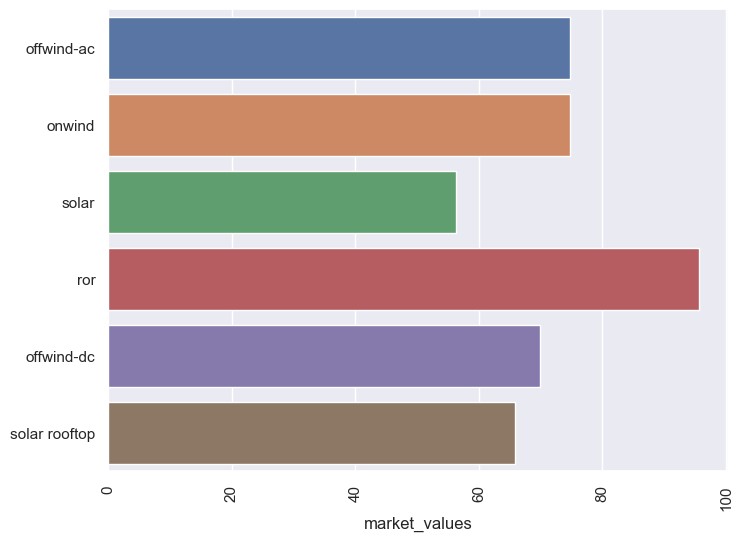

In [6]:
# plot overall market value for all carriers
mv_carriers_mean = pd.DataFrame(mv_carriers.mean())
mv_carriers_mean.columns = ["market_values"]
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data=mv_carriers_mean,y=mv_carriers_mean.index, x="market_values", orient="h")
ticks = plt.xticks(rotation=90)

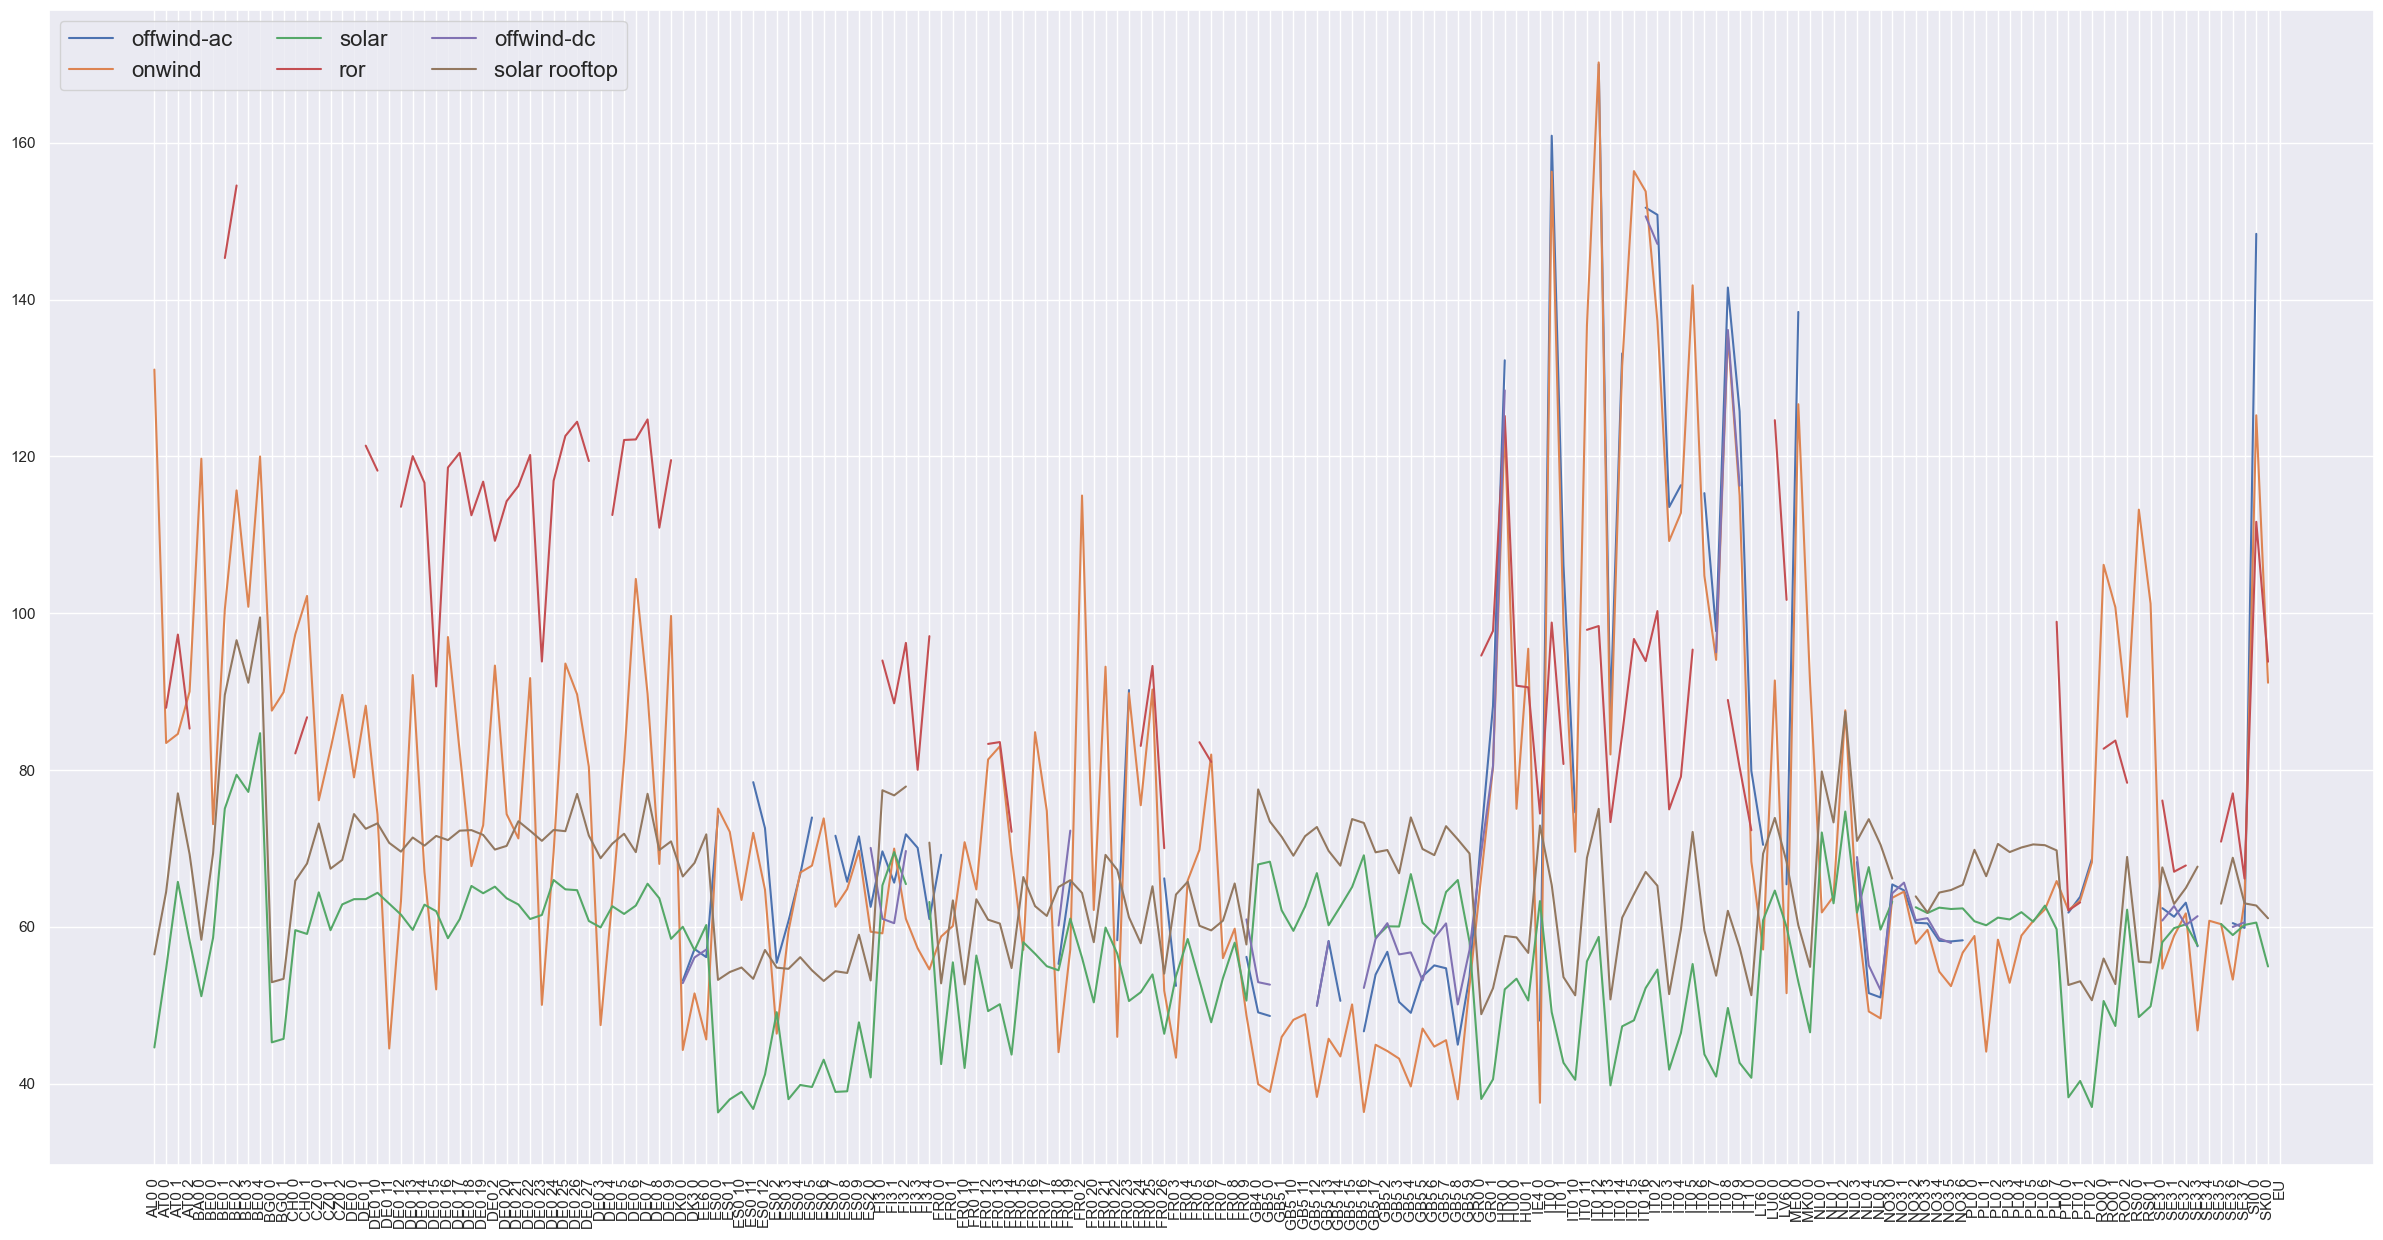

In [7]:
# market value of all carriers for all 181 regions
ax = mv_carriers.plot(figsize=(30,15))
plt.legend(loc='upper left', ncol=3, prop={'size': 16})
ax.set_xticks(range(len(mv_carriers)))
ticks = ax.set_xticklabels(labels = [item for item in mv_carriers.index.tolist()], rotation=90)

In [8]:
mv_carriers

offwind-ac      onwind      solar         ror  offwind-dc  \
AL0 0  126.148417  131.075254  44.628736         NaN         NaN   
AT0 0         NaN   83.457109  54.679083   87.946522         NaN   
AT0 1         NaN   84.612302  65.745903   97.282183         NaN   
AT0 2         NaN   90.012931  58.223787   85.291980         NaN   
BA0 0         NaN  119.715551  51.160537         NaN         NaN   
...           ...         ...        ...         ...         ...   
SE3 6   60.483666   53.277864  58.963028   77.032750   60.000468   
SE3 7   59.877949   63.297661  60.256194   66.164361   60.578980   
SI0 0  148.386481  125.246390  60.556211  111.663140         NaN   
SK0 0         NaN   91.144751  54.957441   93.823663         NaN   
EU            NaN         NaN        NaN         NaN         NaN   

       solar rooftop  
AL0 0      56.499070  
AT0 0      64.462333  
AT0 1      77.031453  
AT0 2      69.284880  
BA0 0      58.363750  
...              ...  
SE3 6      68.822199  
SE3 7      63.005445  
SI0 0      62.729094  
SK0 0      61.104808  
EU               NaN  

[182 rows x 6 columns]

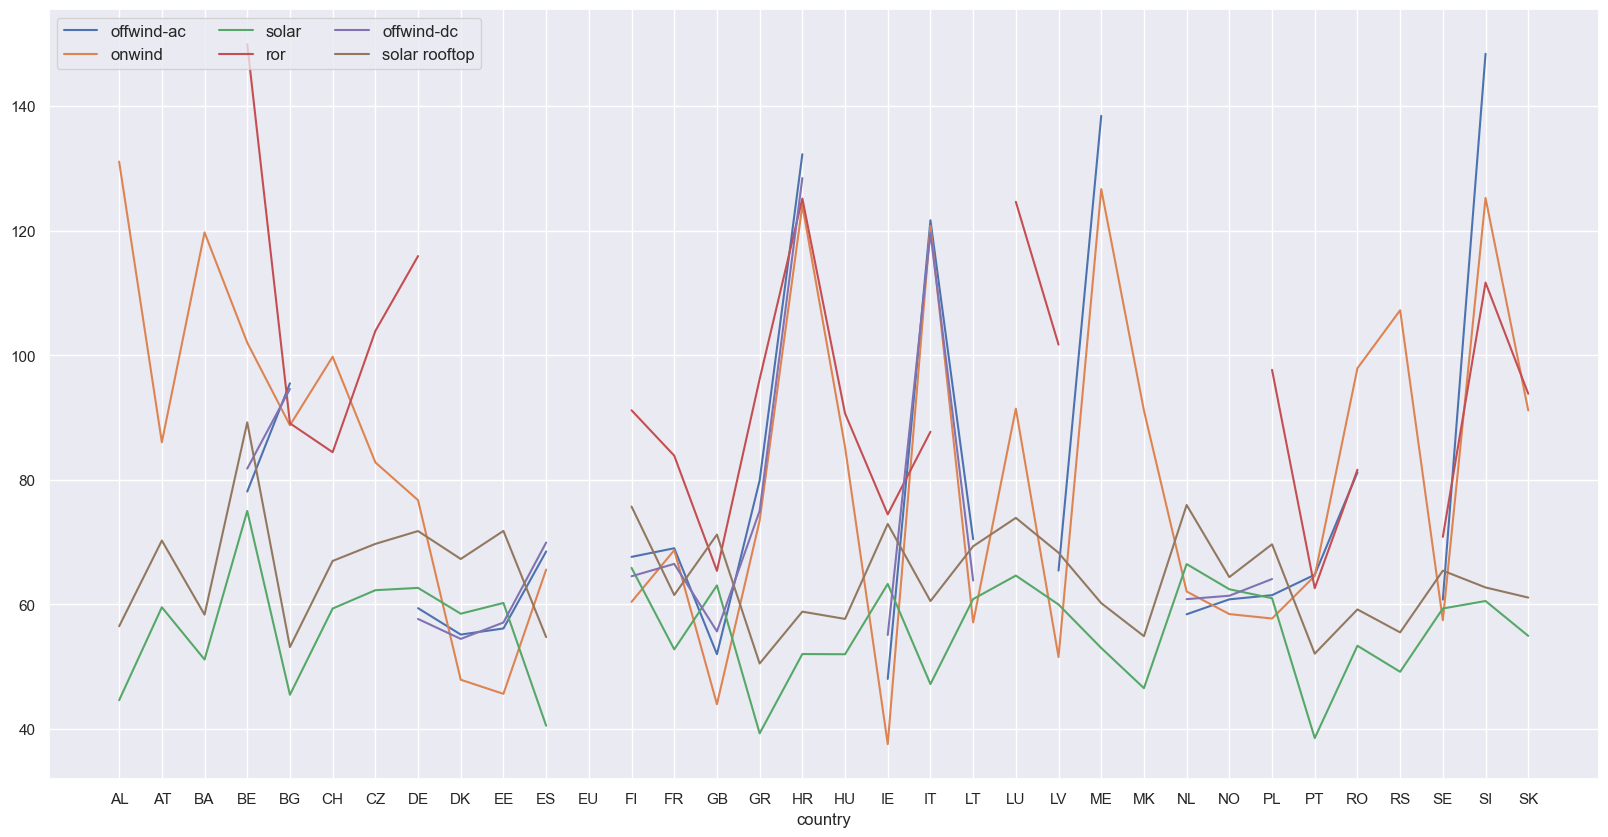

In [9]:
# Plot of mv of carriers by country
mv_carriers["country"] = mv_carriers.index.str[:2]
ax = mv_carriers.groupby(by="country").mean().plot(figsize=(20,10))
plt.legend(loc='upper left', ncol=3, prop={'size': 12})
ax.set_xticks(range(len(mv_carriers.groupby(by="country").mean())))
ticks = ax.set_xticklabels(labels = [item for item in mv_carriers.groupby(by="country").mean().index.tolist()], rotation=0)

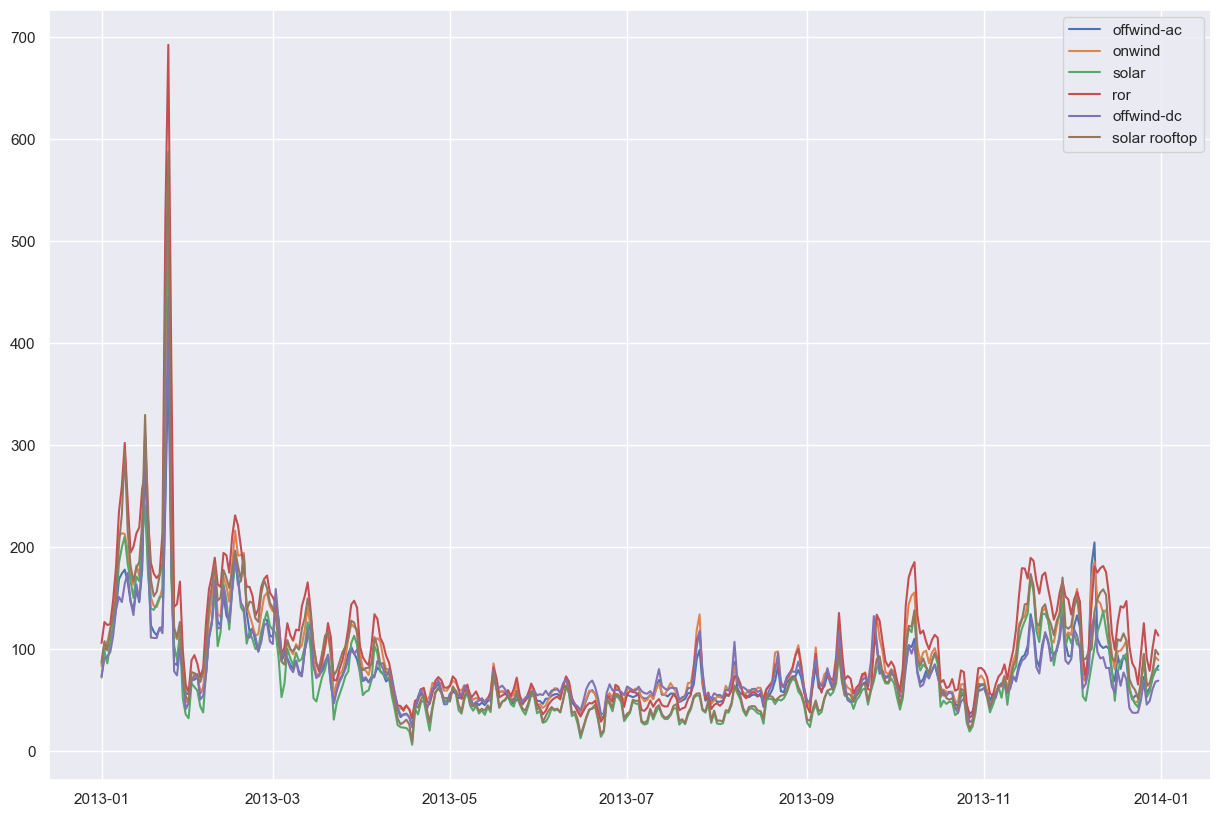

In [10]:
# Plot of market values of carriers for every day
carriers1 = ['offwind-ac','onwind', 'solar','ror','offwind-dc','solar rooftop']

days = pd.DatetimeIndex(np.unique(n.generators_t.p.index.date))
plt.figure(figsize=(15, 10))

for carrier in carriers1:
    mv_daily = market_values_by_time_index(n, days, carrier)
    plt.plot(mv_daily.mean(axis=1), label=carrier)

plt.legend()

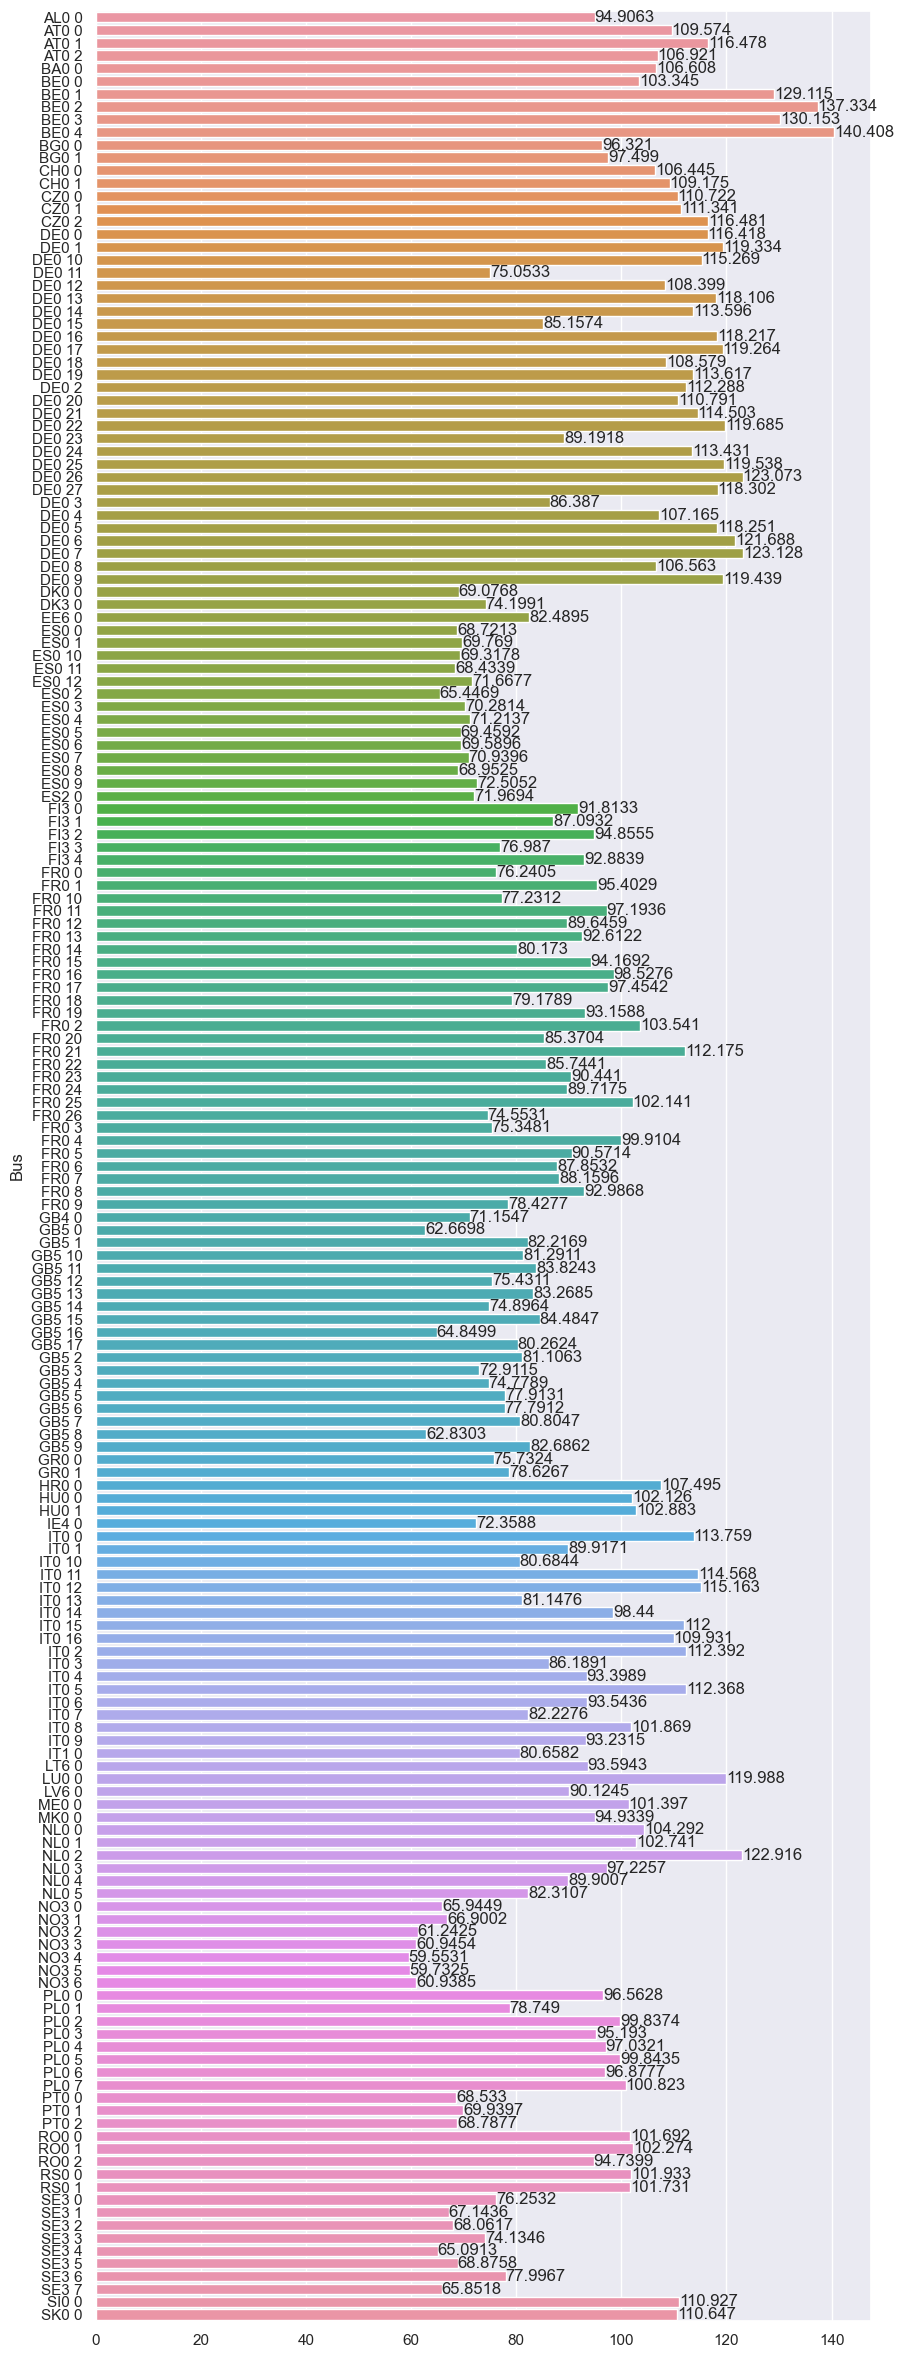

In [11]:
# Plot of all locational marginal prices per regions
lmp_regions = n.buses_t.marginal_price.loc[:, n.buses.location.unique()[:-1]]
df1 = lmp_regions.mean()
sns.set(rc={'figure.figsize':(10,30)})
ax = sns.barplot(y=df1.index, x=df1.values)

for i in ax.containers:
    ax.bar_label(i,)

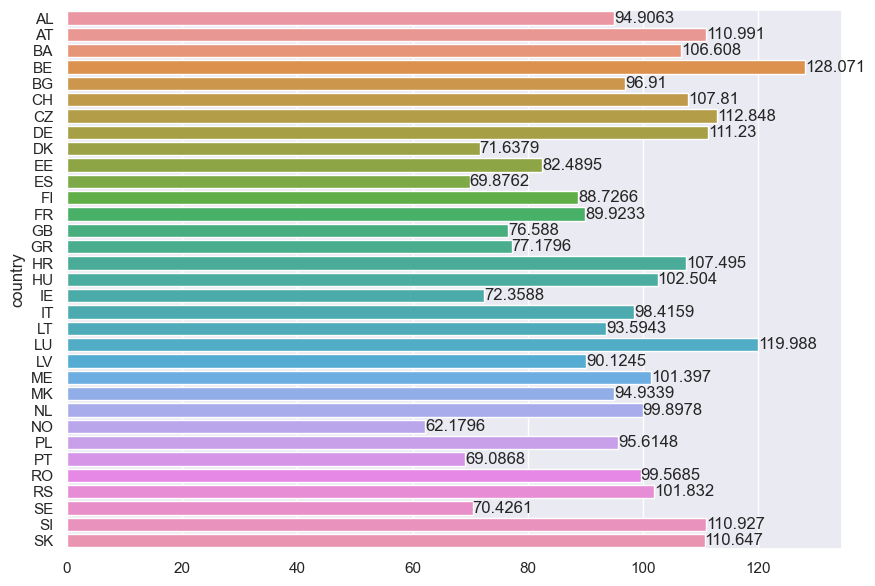

In [12]:
# Plot of lmp averaged over countries
df2 = lmp_regions.transpose()
df2["country"] = df2.index.str[:2]
df2 = df2.groupby(by="country").mean().mean(axis=1)
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.barplot(y=df2.index, x=df2.values)

for i in ax.containers:
    ax.bar_label(i,)

<AxesSubplot: xlabel='snapshot'>

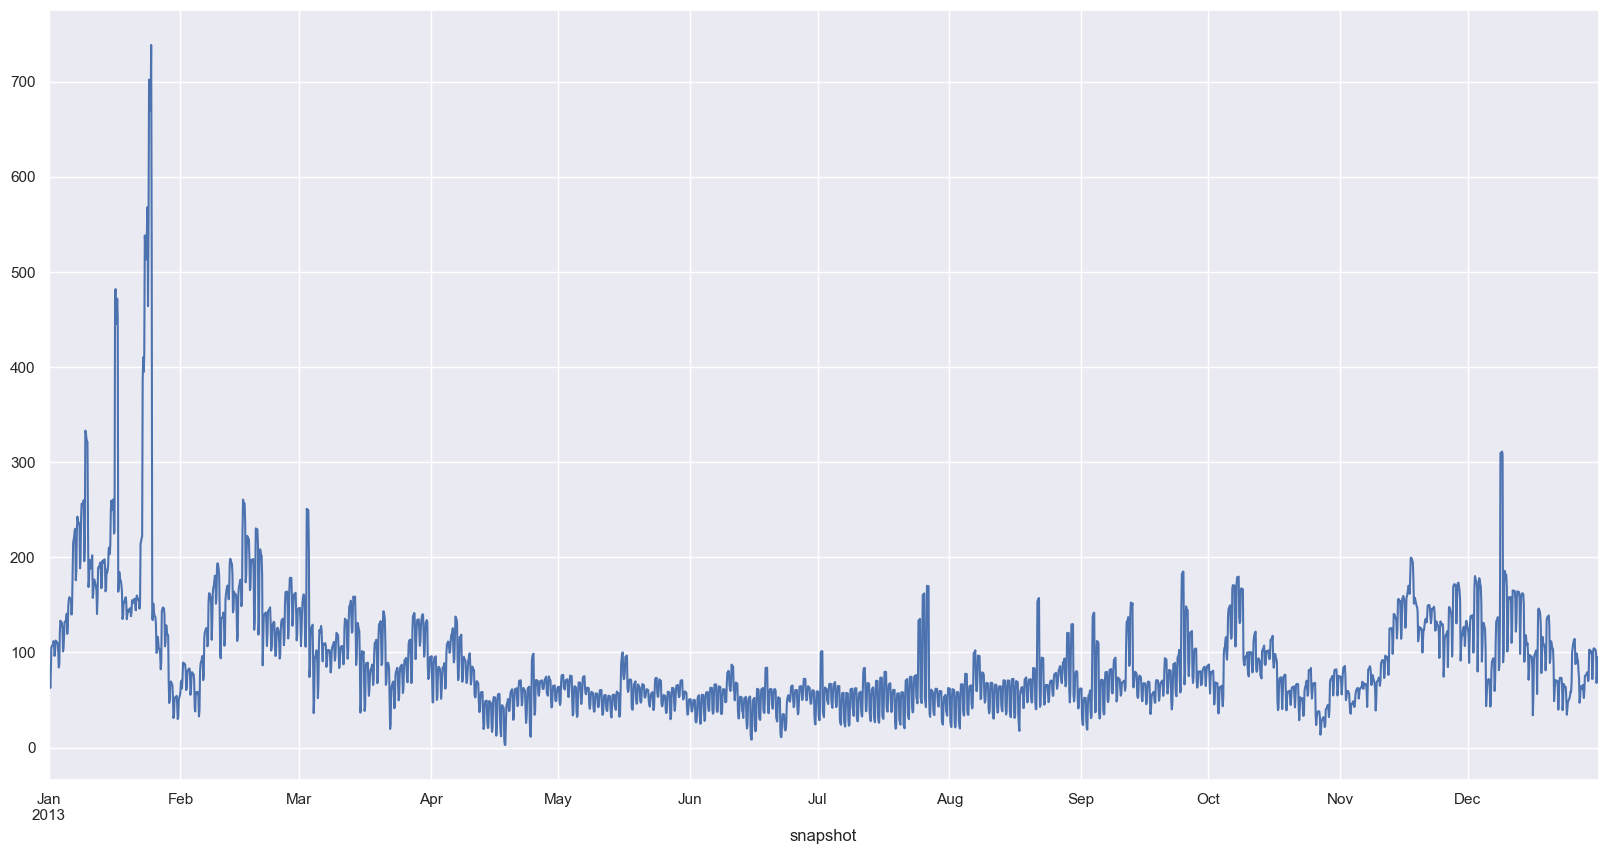

In [13]:
# Plot of average of lmp over 1 year
lmp_regions.mean(axis=1).plot(figsize=(20,10))

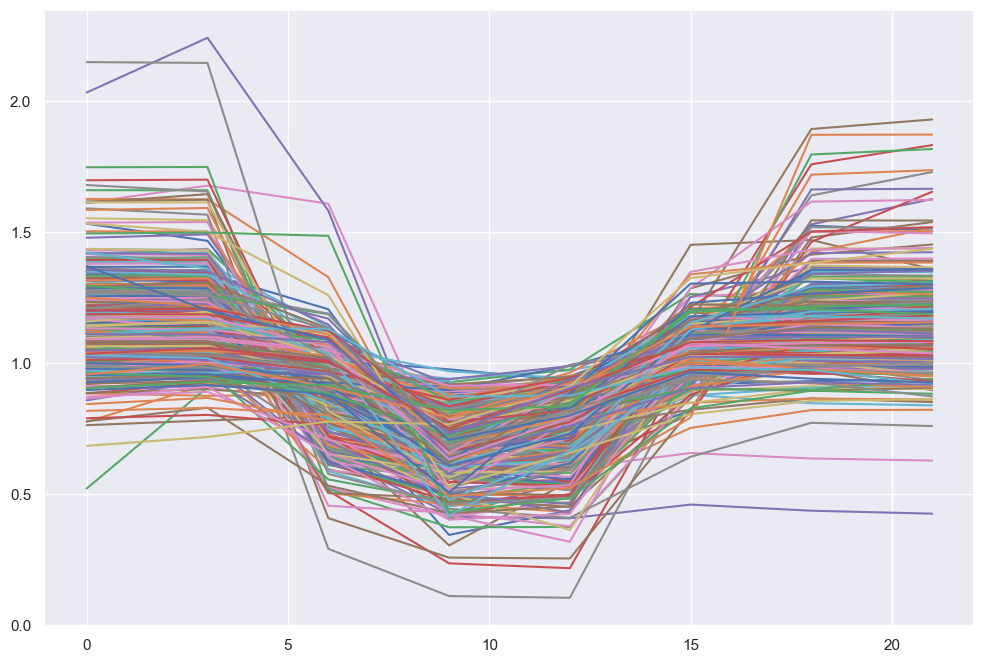

In [14]:
# Plot of lmp daily pattern of lmps normalized by the mean price of the day
plt.figure(figsize=(12, 8))

for day in days:
    df = lmp_regions[lmp_regions.index.date == day.date()].mean(axis=1)
    df_normalized = df / df.mean()
    plt.plot(df_normalized.index.hour, df_normalized.values)

<AxesSubplot: xlabel='hour_of_day', ylabel='market_value'>

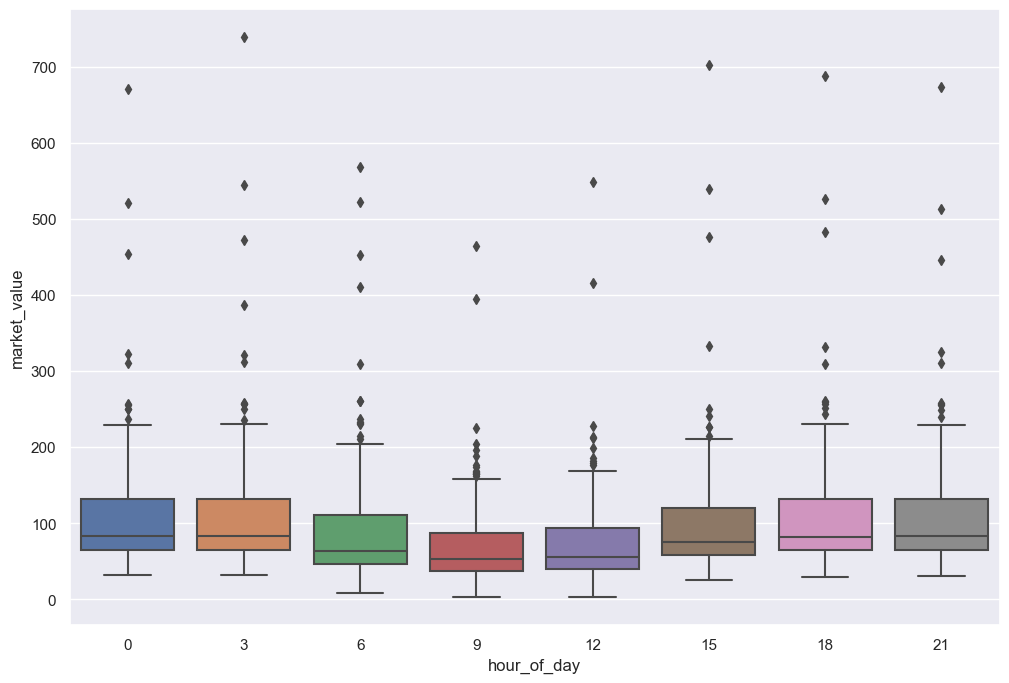

In [15]:
plt.figure(figsize=(12, 8))
df3 = pd.DataFrame(lmp_regions.mean(axis=1))
df3.columns = ["market_value"]
df3["hour_of_day"] = df3.index.hour
sns.boxplot(data=df3, y="market_value", x="hour_of_day")

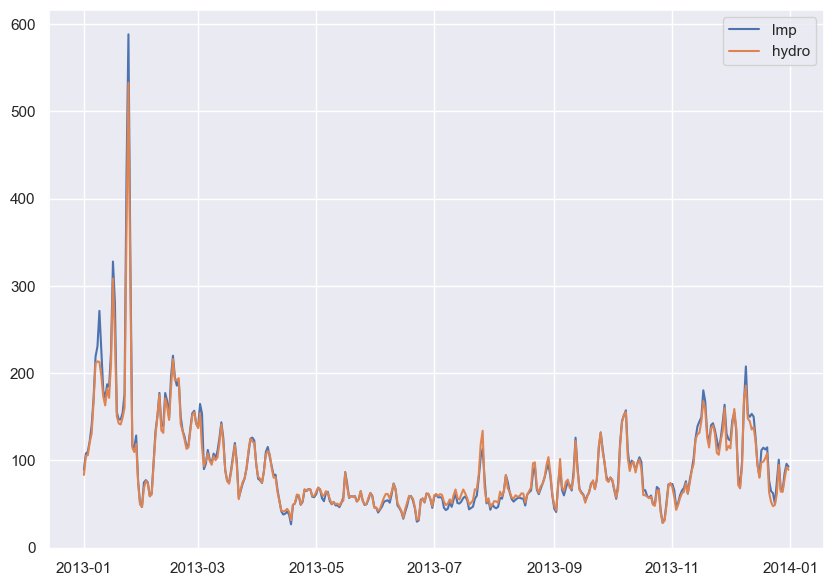

In [16]:
# Plot of daily average of lmp averaged over regions compared to any carrier mv
lmp_regions["indexer"] = lmp_regions.index.date
plt.plot(lmp_regions.groupby(by="indexer").mean().mean(axis=1), label="lmp")
plt.plot(market_values_by_time_index(n,days,"onwind").mean(axis=1), label="hydro")
plt.legend()

### Regional distribution of market values per technology

In [72]:
onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

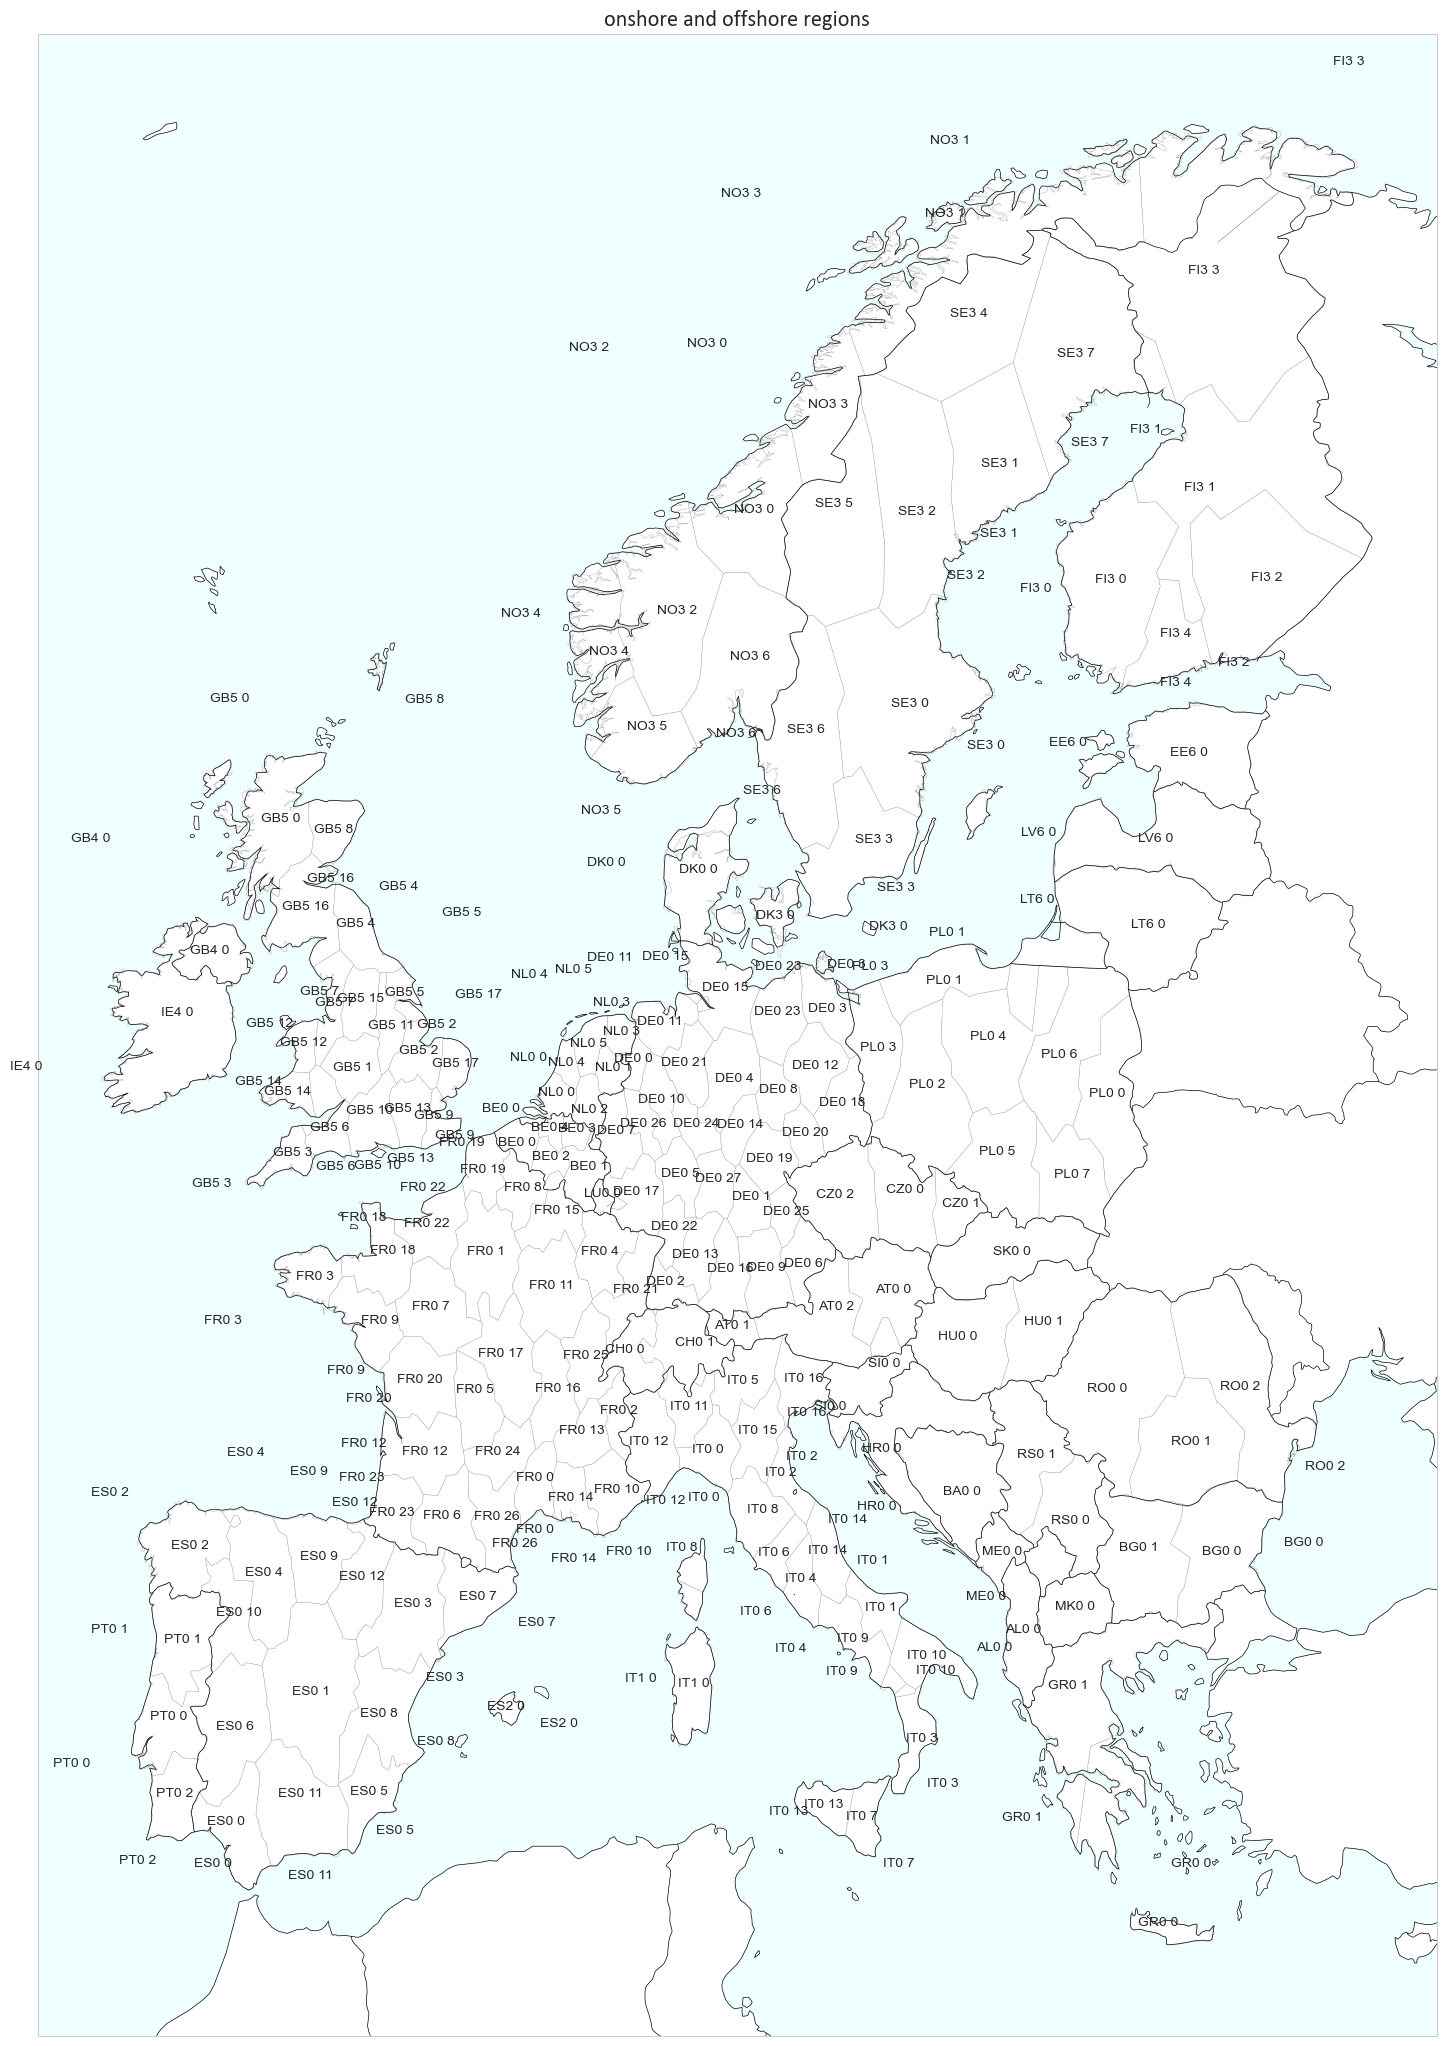

In [75]:
# ToDo plot both regions into same map

fig = plt.figure(figsize=(32, 26))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title("onshore and offshore regions", fontsize=16, **font1)

onshore_regions.plot(ax=ax,
                     transform=ccrs.PlateCarree(),
                     linewidth=0.2,
                     facecolor="white",
                     edgecolor = 'grey')

offshore_regions.plot(ax=ax,
                     transform=ccrs.PlateCarree(),
                     linewidth=0.2,
                     facecolor="white",
                     edgecolor = 'grey')

for idx, row in onshore_regions.iterrows():
    plt.annotate(text=row['name'], xy=row['coords'],
                 horizontalalignment='center')

for idx, row in offshore_regions.iterrows():
    plt.annotate(text=row['name'], xy=row['coords'],
                 horizontalalignment='center')

plt.show()
# plt.close()

In [68]:
# fig.savefig(f"{PLOT_DIR}01_general/regions.png")

In [16]:
# function for carriers in n.generators.carrier.unique() #13
mv_regions_onshore = onshore_regions.copy()
mv_regions_offshore = offshore_regions.copy()

for carrier in n.generators.carrier.unique():
    mv_regions_onshore[carrier] = market_values(n, carrier)
    mv_regions_offshore[carrier] = market_values(n, carrier)

# mv_regions_onshore.to_crs(4326)
# mv_regions_onshore.crs
mv_regions_offshore.head(3)

geometry  offwind-ac  \
name                                                                   
AL0 0  POLYGON ((19.98542 39.69475, 20.01003 39.69120...  126.148417   
BE0 0  POLYGON ((3.25367 51.34858, 3.10403 51.31485, ...   78.122119   
BG0 0  POLYGON ((29.34583 42.24111, 28.32389 41.99778...   95.498412   

           onwind      solar        ror  offwind-dc  gas  \
name                                                       
AL0 0  131.075254  44.628736        NaN         NaN  NaN   
BE0 0   73.103671  58.613241        NaN   81.809493  NaN   
BG0 0   87.582734  45.281165  89.073902   94.596314  NaN   

       residential rural solar thermal  services rural solar thermal  \
name                                                                   
AL0 0                        28.100521                     28.138751   
BE0 0                        29.260113                     29.615834   
BG0 0                        26.863697                     26.077307   

       residential urban decentral solar thermal  \
name                                               
AL0 0                                  36.469361   
BE0 0                                  34.840251   
BG0 0                                  36.446881   

       services urban decentral solar thermal  urban central solar thermal  \
name                                                                         
AL0 0                               35.507220                    45.096866   
BE0 0                               33.749229                    34.889495   
BG0 0                               35.670798                    31.907542   

       oil  solar rooftop  
name                       
AL0 0  NaN      56.499070  
BE0 0  NaN      69.372367  
BG0 0  NaN      52.951120

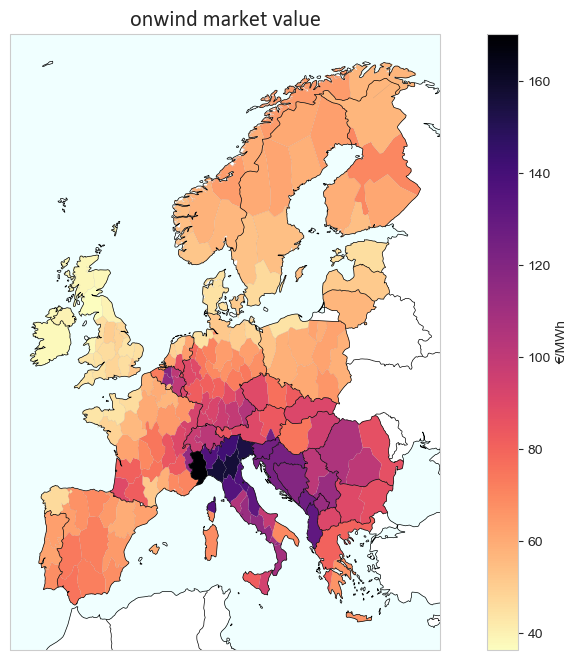

In [82]:
carrier = "onwind"

fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier} market value", fontsize=16, **font1)

mv_regions_onshore.plot(column=carrier,
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€/MWh",
                        'orientation': "vertical"})

plt.show()

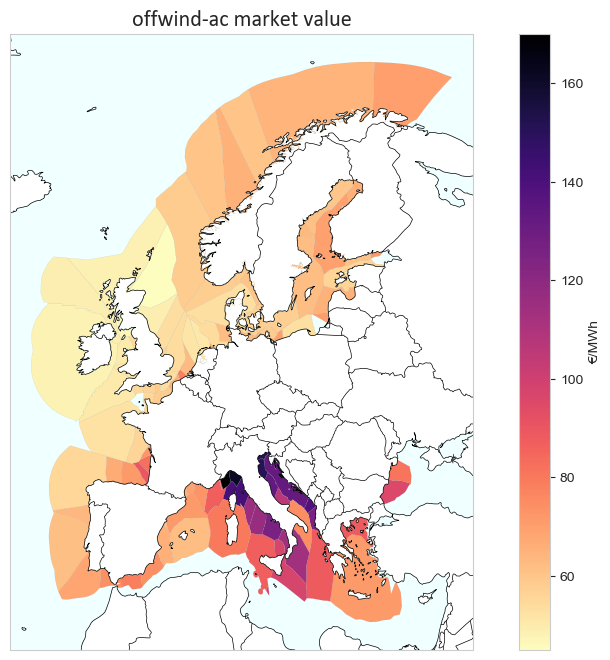

In [18]:
carrier = "offwind-ac"

fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier} market value", fontsize=16, **font1)

mv_regions_offshore.plot(column=carrier,
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€/MWh",
                        'orientation': "vertical"})

plt.show()

In [19]:
# fig.savefig('test.png')

In [20]:
# function for carriers in n.links.carrier.unique() #53
#  H2 Electrolysis , residential urban decentral air heat pump, Fischer-Tropsch, Sabatier, OCGT, battery charger, home battery charger, 'urban central gas CHP' , urban central gas CHP CC, urban central gas boiler, residential rural gas boiler, residential rural resistive heater, services rural resistive heater
mv_regions_onshore_links = onshore_regions.copy()

for carrier in n.links.carrier.unique():
    mv_regions_onshore_links[carrier] = market_values_links(n, carrier)

mv_regions_onshore_links.head(3)

geometry  DC        OCGT  \
name                                                                       
AL0 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809... NaN  304.051963   
AT0 0  POLYGON ((16.45660 47.41184, 16.43396 47.39685... NaN  312.461515   
AT0 1  POLYGON ((10.08288 47.35907, 10.20928 47.37248... NaN  424.822735   

       H2 Electrolysis  H2 Fuel Cell  battery charger  battery discharger  \
name                                                                        
AL0 0        66.637006    120.601890        65.385803          106.129725   
AT0 0        82.512572    137.047324        76.587549          111.397523   
AT0 1        90.305267    140.326233        89.375799          130.615348   

       Sabatier      SMR CC         SMR  ...  gas for industry  \
name                                     ...                     
AL0 0       NaN  200.591784  217.661113  ...               NaN   
AT0 0       NaN  169.303966  220.840330  ...               NaN   
AT0 1       NaN  170.887707  249.070483  ...               NaN   

       gas for industry CC  H2 liquefaction  Fischer-Tropsch  \
name                                                           
AL0 0                  NaN       137.617875              NaN   
AT0 0                  NaN       151.448316              NaN   
AT0 1                  NaN       154.026970              NaN   

       process emissions  process emissions CC  DAC  \
name                                                  
AL0 0                NaN                   NaN  NaN   
AT0 0                NaN                   NaN  NaN   
AT0 1                NaN                   NaN  NaN   

       electricity distribution grid  home battery charger  \
name                                                         
AL0 0                     118.132568             78.253283   
AT0 0                     117.569587             92.118676   
AT0 1                     125.877730             98.323916   

       home battery discharger  
name                            
AL0 0                86.106855  
AT0 0               100.313215  
AT0 1               106.597094  

[3 rows x 54 columns]

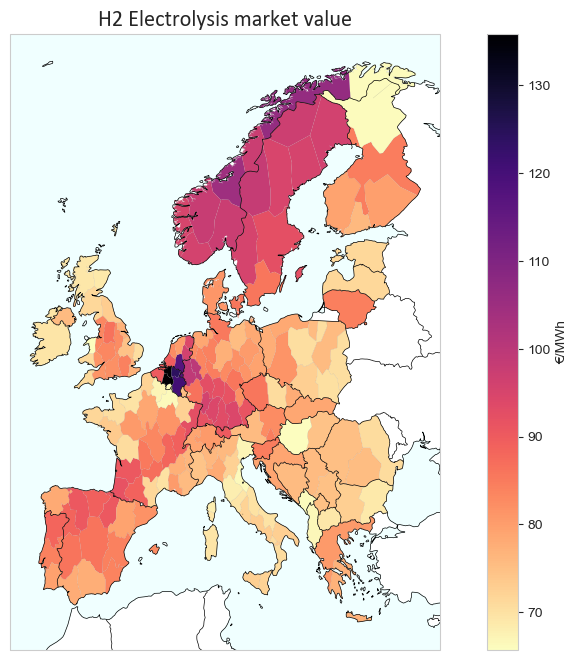

In [84]:
carrier = "H2 Electrolysis" # H2 Electrolysis, H2 Fuel Cell

fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier} market value", fontsize=16, **font1)

mv_regions_onshore_links.plot(column=carrier,
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€/MWh",
                        'orientation': "vertical"})

plt.show()

In [85]:
# most expensive regions
mv_regions_onshore_links[carrier].sort_values(ascending=False)

name
BE0 4     135.862687
BE0 2     135.790218
BE0 3     124.161770
BE0 1     120.540365
NL0 2     117.425785
             ...    
FR0 15     66.278875
ME0 0      66.154728
FI3 3      66.049500
GB5 12     65.727448
HU0 0      65.676002
Name: H2 Electrolysis, Length: 181, dtype: float64

In [37]:
# carriers for which market_values function does not work
# -> there are 24 carrier which are not a generators but attached to a bus; from the generators only 2 are also attached to buses {'gas', 'oil'}
# all renewables are produced at generators and are not directly attached to a bus; the generator is attached to the bus (thats also why they do not have lmps)
# set(n.buses.carrier.tolist()) - set(n.generators.carrier.tolist()) # 24

### Spatial and temporal distribution of prices:

- electricity
- heat (various subcategories)
- hydrogen

#### Nodal Prices for every time step (sum) - heatmap

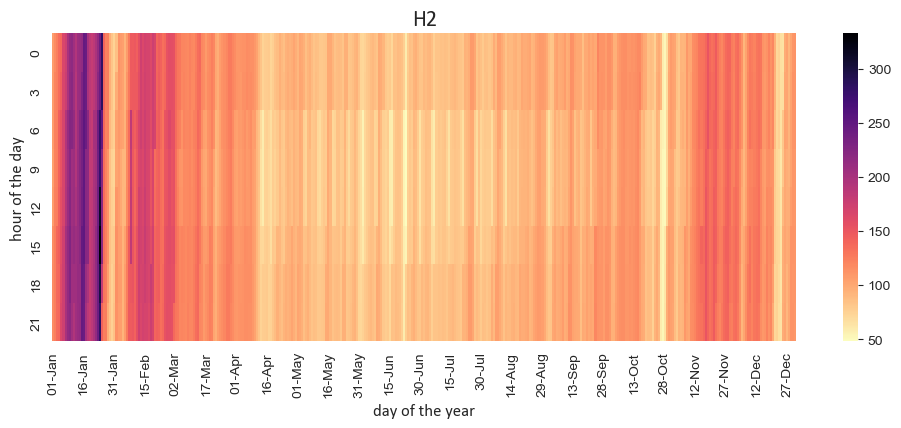

In [115]:
carrier = "H2" # H2, services rural heat, low voltage (no values for VRE as they do not have their own buses)
# change to mean for
df = pd.DataFrame(n.buses_t.marginal_price[n.buses[n.buses.carrier==carrier].index].mean(axis=1))

hours = df.index.hour.unique()
df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

for hour in hours:
    df_start[str(hour)] = df[df.index.hour==hour].values

plt.figure(figsize=(12, 4))
ax = sns.heatmap(df_start.transpose(),
                 cmap=plt.get_cmap("magma_r"),
                 linewidth=0.001,
                 xticklabels=15)
plt.title(str(carrier), fontsize=16, **font1)
plt.ylabel("hour of the day", fontsize=12, **font1)
plt.xlabel("day of the year", fontsize=12, **font1)

# Rewrite the y labels
x_labels = ax.get_xticks()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

plt.show()

### Time series analysis:

- when do different technologies produce?
- when are their revenues created? (nodal price * production) (e.g. like
attached graphic)
- what are the prices when they produce?


#### Technology Operation and Revenue by Price band

In [27]:
# plot percentage of production per price band and percentage of revenue per price band
carriers_gen = ["onwind", "solar", "ror", "offwind-dc", "gas"]
carriers_link = ["H2 Electrolysis", "H2 Fuel Cell"]
carriers_labels = (carriers_gen + carriers_link)
price_bands = [0, 5, 50, 100, 200, 1000, np.inf]
price_bands_labels = ["0 - 5", "5 - 50", "50 - 100", "100 - 200", "200 - 1000", "> 1000"]
res_prod = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers_labels)
res_rev = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers_labels)

In [28]:
for carrier in carriers_gen:
    gen = n.generators_t.p.loc[:, n.generators.carrier == carrier]
    gen.columns = gen.columns.map(n.generators.bus)
    lmp = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp

    for i in range(len(price_bands)-1):
        lmp_cat = lmp.mask((lmp >= price_bands[i]) & (lmp < price_bands[i+1]), "hit")
        res_prod.loc[str(i), carrier] = gen[lmp_cat == "hit"].sum().sum() / gen.sum().sum()
        res_rev.loc[str(i), carrier] = rev[lmp_cat == "hit"].sum().sum() / rev.sum().sum()

for carrier in carriers_link:
    # prices of the generated energy
    gen = abs(n.links_t.p1.loc[:, n.links.carrier == carrier])
    gen.columns = gen.columns.map(n.links.bus1)
    lmp = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp

    for i in range(len(price_bands)-1):
        lmp_cat = lmp.mask((lmp >= price_bands[i]) & (lmp < price_bands[i+1]), "hit")
        res_prod.loc[str(i), carrier] = gen[lmp_cat == "hit"].sum().sum() / gen.sum().sum()
        res_rev.loc[str(i), carrier] = rev[lmp_cat == "hit"].sum().sum() / rev.sum().sum()

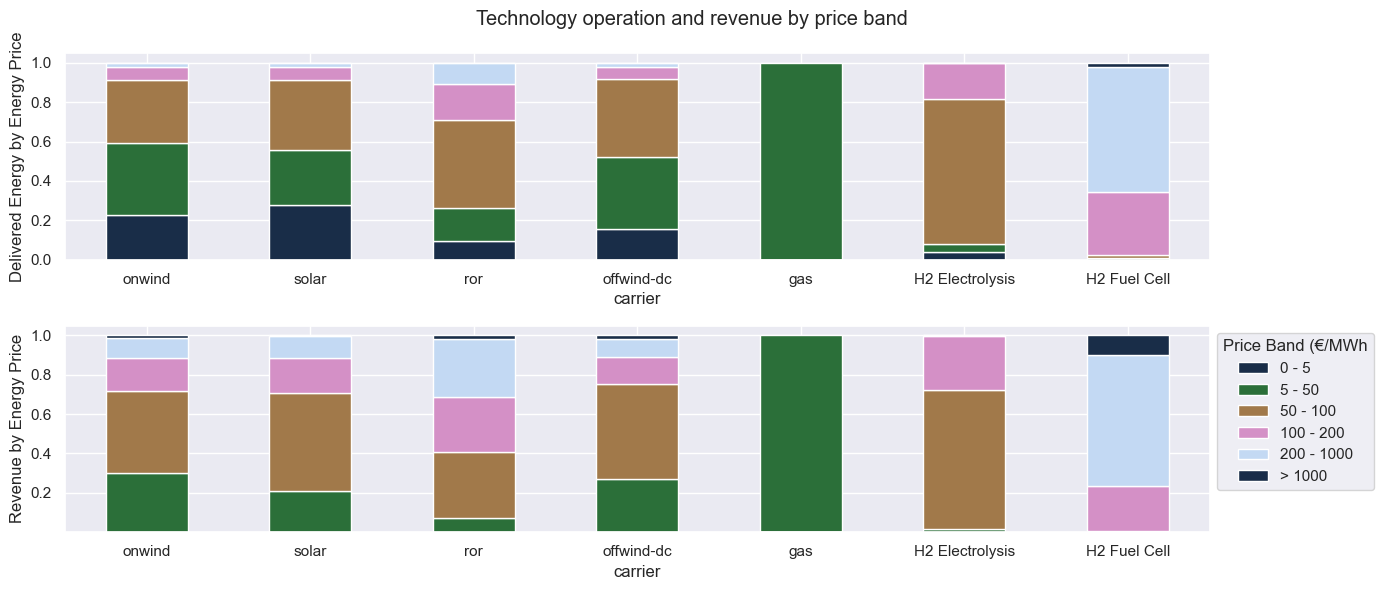

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

fig.suptitle('Technology operation and revenue by price band')

ax0 = res_prod.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("cubehelix", 5), ax=axes[0], legend=False)
ax0.set_ylabel("Delivered Energy by Energy Price")
ax0.set_xlabel("carrier")
ax0.set_xticks(ticks=range(len(carriers_labels)), labels=carriers_labels, rotation=0)

ax1 = res_rev.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("cubehelix", 5), ax=axes[1])
ax1.legend(title='Price Band (€/MWh', labels=price_bands_labels, bbox_to_anchor=(1, 1))
ax1.set_ylabel("Revenue by Energy Price")
ax1.set_xlabel("carrier")
ax1.set_xticks(ticks=range(len(carriers_labels)), labels=carriers_labels, rotation=0)

fig.tight_layout()

#### Energy conversion technologies production and revenue by input technology price band (links)

In [30]:
carriers_link2 = ["OCGT", "H2 Electrolysis", "Fischer-Tropsch","Sabatier", "H2 Fuel Cell", "urban central gas CHP", "urban central gas CHP CC", "battery charger", "battery discharger", "home battery charger", "home battery discharger"   ]
carriers_links_resisitve_heater = ["residential rural resistive heater", "services rural resistive heater", "residential urban decentral resistive heater", "services urban decentral resistive heater", "urban central resistive heater" ]
carriers_links_heat_pumps = ["residential rural ground heat pump", "services rural ground heat pump", "residential urban decentral air heat pump", "services urban decentral air heat pump", "urban central air heat pump"  ]
carriers_links_gas_boiler = ["residential rural gas boiler", "services rural gas boiler", "residential urban decentral gas boiler", "services urban decentral gas boiler", "urban central gas boiler"]

my_carriers = carriers_link2

res_prod2 = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=my_carriers)
res_rev2 = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=my_carriers)

In [31]:
for carrier in my_carriers:
# prices of the consumed energy
    con = n.links_t.p0.loc[:, n.links.carrier == carrier]
    transform_columns = n.links_t.p0.loc[:, n.links.carrier == carrier].columns.map(n.links.bus1)
    con.columns = con.columns.map(n.links.bus0)
    lmp_con = n.buses_t.marginal_price.loc[:, con.columns]
    cost = con * lmp_con

    gen = abs(n.links_t.p1.loc[:, n.links.carrier == carrier])
    gen.columns = gen.columns.map(n.links.bus1)
    lmp_gen = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp_gen

    for i in range(len(price_bands)-1):
        lmp_cat1 = lmp_con.mask((lmp_con >= price_bands[i]) & (lmp_con < price_bands[i+1]), "hit")
        # pay attention to indices (if something went wrong then probably here)
        lmp_cat1.columns = transform_columns
        res_prod2.loc[str(i), carrier] = gen[lmp_cat1 == "hit"].sum().sum() / gen.sum().sum()
        res_rev2.loc[str(i), carrier] = rev[lmp_cat1 == "hit"].sum().sum() / rev.sum().sum()

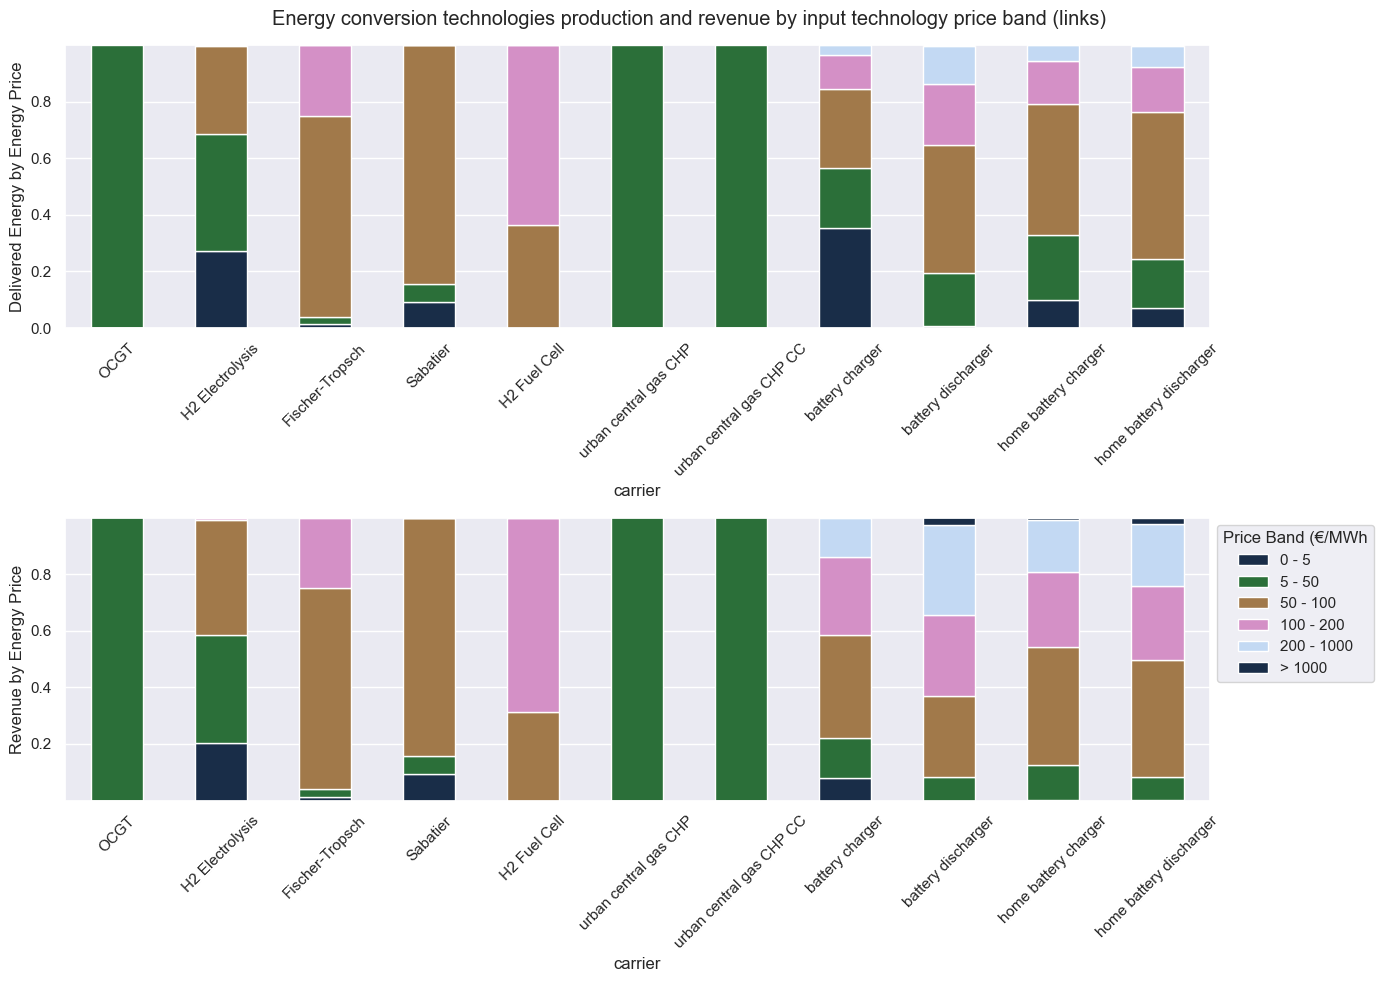

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

fig.suptitle('Energy conversion technologies production and revenue by input technology price band (links) ')

ax0 = res_prod2.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("cubehelix", 5), ax=axes[0], legend=False)
ax0.set_ylabel("Delivered Energy by Energy Price")
ax0.set_xlabel("carrier")
ax0.set_xticks(ticks=range(len(my_carriers)), labels=my_carriers, rotation=45)

ax1 = res_rev2.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("cubehelix", 5), ax=axes[1])
ax1.legend(title='Price Band (€/MWh', labels=price_bands_labels, bbox_to_anchor=(1, 1))
ax1.set_ylabel("Revenue by Energy Price")
ax1.set_xlabel("carrier")
ax1.set_xticks(ticks=range(len(my_carriers)), labels=my_carriers, rotation=45)

fig.tight_layout()

### Congestion rent
Additionally: Calculate congestion rents for link components of the
above list.

price difference i-j * flow i-j

- maybe also for line components?

In [33]:
cr_res1 = pd.DataFrame(index = range(1), columns=carriers_link2)
for carrier in carriers_link2:
    cr_res1[carrier] =congestion_rent_link(n,carrier).sum().sum()

In [34]:
cr_res1

OCGT  H2 Electrolysis  Fischer-Tropsch      Sabatier  H2 Fuel Cell  \
0  3.788702e+08     1.949022e+10     1.152440e+10  2.568020e+09  3.902577e+07   

   urban central gas CHP  urban central gas CHP CC  battery charger  \
0           3.805257e+09               426744.0846     1.565694e+09   

   battery discharger  home battery charger  home battery discharger  
0        3.271599e+07         -66993.994645             -79793.63527

In [35]:
carrier = carriers_link2[9]
print(carrier)

home battery charger


In [36]:
n.links[n.links.carrier == carrier]

bus0                bus1  \
Link                                                                
AL0 0 home battery charger  AL0 0 low voltage  AL0 0 home battery   
AT0 0 home battery charger  AT0 0 low voltage  AT0 0 home battery   
AT0 1 home battery charger  AT0 1 low voltage  AT0 1 home battery   
AT0 2 home battery charger  AT0 2 low voltage  AT0 2 home battery   
BA0 0 home battery charger  BA0 0 low voltage  BA0 0 home battery   
...                                       ...                 ...   
SE3 5 home battery charger  SE3 5 low voltage  SE3 5 home battery   
SE3 6 home battery charger  SE3 6 low voltage  SE3 6 home battery   
SE3 7 home battery charger  SE3 7 low voltage  SE3 7 home battery   
SI0 0 home battery charger  SI0 0 low voltage  SI0 0 home battery   
SK0 0 home battery charger  SK0 0 low voltage  SK0 0 home battery   

                                         carrier geometry  length  p_nom tags  \
Link                                                                            
AL0 0 home battery charger  home battery charger              0.0    0.0        
AT0 0 home battery charger  home battery charger              0.0    0.0        
AT0 1 home battery charger  home battery charger              0.0    0.0        
AT0 2 home battery charger  home battery charger              0.0    0.0        
BA0 0 home battery charger  home battery charger              0.0    0.0        
...                                          ...      ...     ...    ...  ...   
SE3 5 home battery charger  home battery charger              0.0    0.0        
SE3 6 home battery charger  home battery charger              0.0    0.0        
SE3 7 home battery charger  home battery charger              0.0    0.0        
SI0 0 home battery charger  home battery charger              0.0    0.0        
SK0 0 home battery charger  home battery charger              0.0    0.0        

                            under_construction  underground  p_min_pu  ...  \
Link                                                                   ...   
AL0 0 home battery charger                 NaN          NaN       0.0  ...   
AT0 0 home battery charger                 NaN          NaN       0.0  ...   
AT0 1 home battery charger                 NaN          NaN       0.0  ...   
AT0 2 home battery charger                 NaN          NaN       0.0  ...   
BA0 0 home battery charger                 NaN          NaN       0.0  ...   
...                                        ...          ...       ...  ...   
SE3 5 home battery charger                 NaN          NaN       0.0  ...   
SE3 6 home battery charger                 NaN          NaN       0.0  ...   
SE3 7 home battery charger                 NaN          NaN       0.0  ...   
SI0 0 home battery charger                 NaN          NaN       0.0  ...   
SK0 0 home battery charger                 NaN          NaN       0.0  ...   

                            p_nom_opt  charger_ratio  type  build_year  \
Link                                                                     
AL0 0 home battery charger   0.243027  -15706.759805                 0   
AT0 0 home battery charger   0.235679  -15903.109975                 0   
AT0 1 home battery charger   0.219218  -15960.065890                 0   
AT0 2 home battery charger   0.233202  -15878.466909                 0   
BA0 0 home battery charger   0.269320  -15918.849742                 0   
...                               ...            ...   ...         ...   
SE3 5 home battery charger   0.251188  -16159.505336                 0   
SE3 6 home battery charger   0.240945  -16209.435966                 0   
SE3 7 home battery charger   0.252951  -16185.789420                 0   
SI0 0 home battery charger   0.227454  -15938.055989                 0   
SK0 0 home battery charger   0.247400  -15572.085745                 0   

                           p_nom_min p_set p_max_pu  terrain_factor  \
Link                                    

In [37]:
n.links[n.links.carrier == carrier]

bus0                bus1  \
Link                                                                
AL0 0 home battery charger  AL0 0 low voltage  AL0 0 home battery   
AT0 0 home battery charger  AT0 0 low voltage  AT0 0 home battery   
AT0 1 home battery charger  AT0 1 low voltage  AT0 1 home battery   
AT0 2 home battery charger  AT0 2 low voltage  AT0 2 home battery   
BA0 0 home battery charger  BA0 0 low voltage  BA0 0 home battery   
...                                       ...                 ...   
SE3 5 home battery charger  SE3 5 low voltage  SE3 5 home battery   
SE3 6 home battery charger  SE3 6 low voltage  SE3 6 home battery   
SE3 7 home battery charger  SE3 7 low voltage  SE3 7 home battery   
SI0 0 home battery charger  SI0 0 low voltage  SI0 0 home battery   
SK0 0 home battery charger  SK0 0 low voltage  SK0 0 home battery   

                                         carrier geometry  length  p_nom tags  \
Link                                                                            
AL0 0 home battery charger  home battery charger              0.0    0.0        
AT0 0 home battery charger  home battery charger              0.0    0.0        
AT0 1 home battery charger  home battery charger              0.0    0.0        
AT0 2 home battery charger  home battery charger              0.0    0.0        
BA0 0 home battery charger  home battery charger              0.0    0.0        
...                                          ...      ...     ...    ...  ...   
SE3 5 home battery charger  home battery charger              0.0    0.0        
SE3 6 home battery charger  home battery charger              0.0    0.0        
SE3 7 home battery charger  home battery charger              0.0    0.0        
SI0 0 home battery charger  home battery charger              0.0    0.0        
SK0 0 home battery charger  home battery charger              0.0    0.0        

                            under_construction  underground  p_min_pu  ...  \
Link                                                                   ...   
AL0 0 home battery charger                 NaN          NaN       0.0  ...   
AT0 0 home battery charger                 NaN          NaN       0.0  ...   
AT0 1 home battery charger                 NaN          NaN       0.0  ...   
AT0 2 home battery charger                 NaN          NaN       0.0  ...   
BA0 0 home battery charger                 NaN          NaN       0.0  ...   
...                                        ...          ...       ...  ...   
SE3 5 home battery charger                 NaN          NaN       0.0  ...   
SE3 6 home battery charger                 NaN          NaN       0.0  ...   
SE3 7 home battery charger                 NaN          NaN       0.0  ...   
SI0 0 home battery charger                 NaN          NaN       0.0  ...   
SK0 0 home battery charger                 NaN          NaN       0.0  ...   

                            p_nom_opt  charger_ratio  type  build_year  \
Link                                                                     
AL0 0 home battery charger   0.243027  -15706.759805                 0   
AT0 0 home battery charger   0.235679  -15903.109975                 0   
AT0 1 home battery charger   0.219218  -15960.065890                 0   
AT0 2 home battery charger   0.233202  -15878.466909                 0   
BA0 0 home battery charger   0.269320  -15918.849742                 0   
...                               ...            ...   ...         ...   
SE3 5 home battery charger   0.251188  -16159.505336                 0   
SE3 6 home battery charger   0.240945  -16209.435966                 0   
SE3 7 home battery charger   0.252951  -16185.789420                 0   
SI0 0 home battery charger   0.227454  -15938.055989                 0   
SK0 0 home battery charger   0.247400  -15572.085745                 0   

                           p_nom_min p_set p_max_pu  terrain_factor  \
Link                                    

In [38]:
n.links_t["p1"].loc[:, n.links.carrier == carrier]

Link                 AL0 0 home battery charger  AT0 0 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.057332                   -0.047223   
2013-01-01 03:00:00                   -0.048150                   -0.048121   
2013-01-01 06:00:00                   -0.098990                   -0.113736   
2013-01-01 09:00:00                   -0.139708                   -0.111300   
2013-01-01 12:00:00                   -0.146668                   -0.131920   
...                                         ...                         ...   
2013-12-31 09:00:00                   -0.093937                   -0.121545   
2013-12-31 12:00:00                   -0.104720                   -0.090576   
2013-12-31 15:00:00                   -0.052112                   -0.085015   
2013-12-31 18:00:00                   -0.058364                   -0.088546   
2013-12-31 21:00:00                   -0.059445                   -0.110782   

Link                 AT0 1 home battery charger  AT0 2 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.116514                   -0.094273   
2013-01-01 03:00:00                   -0.102358                   -0.086354   
2013-01-01 06:00:00                   -0.100093                   -0.085145   
2013-01-01 09:00:00                   -0.103028                   -0.095870   
2013-01-01 12:00:00                   -0.133621                   -0.121373   
...                                         ...                         ...   
2013-12-31 09:00:00                   -0.139965                   -0.136495   
2013-12-31 12:00:00                   -0.129109                   -0.124517   
2013-12-31 15:00:00                   -0.078631                   -0.058203   
2013-12-31 18:00:00                   -0.078182                   -0.058980   
2013-12-31 21:00:00                   -0.073023                   -0.080002   

Link                 BA0 0 home battery charger  BE0 0 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.062636                   -0.115175   
2013-01-01 03:00:00                   -0.052195                   -0.115318   
2013-01-01 06:00:00                   -0.128004                   -0.119709   
2013-01-01 09:00:00                   -0.168427                   -0.131787   
2013-01-01 12:00:00                   -0.178215                   -0.155555   
...                                         ...                         ...   
2013-12-31 09:00:00                   -0.107877                   -0.119108   
2013-12-31 12:00:00                   -0.162331                   -0.119476   
2013-12-31 15:00:00                   -0.038294                   -0.118475   
2013-12-31 18:00:00                   -0.063647                   -0.116229   
2013-12-31 21:00:00                   -0.060845                   -0.114541   

Link                 BE0 1 home battery charger  BE0 2 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.115521                   -0.075236   
2013-01-01 03:00:00                   -0.073792                   -0.076529   
2013-01-01 06:00:00                   -0.087938                   -0.079545   
2013-01-01 09:00:00                   -0.120067                   -0.090123   
2013-01-01 12:00:00                   -0.134129                   -0.114283   
...                                         ...                         ...   
2013-12-31 09:00:00                   -0.133086                   -0.112294   
2013-12-31 12:00:00                   -0.110262                   -0.083719   
2013-12-31 15:00:00                   -0.107351                   -0.081243   
2013-12-31 18:00:00                   -0.103021

In [39]:
n.buses_t.marginal_price[n.links["bus1"][n.links.carrier == carrier]]

Bus                  AL0 0 home battery  AT0 0 home battery  \
snapshot                                                      
2013-01-01 00:00:00          207.193448          191.840970   
2013-01-01 03:00:00          205.714306          191.938123   
2013-01-01 06:00:00          169.934834          186.492179   
2013-01-01 09:00:00          167.097474          186.338301   
2013-01-01 12:00:00          167.635541          187.467121   
...                                 ...                 ...   
2013-12-31 09:00:00          201.531371          186.949753   
2013-12-31 12:00:00          202.085946          185.405736   
2013-12-31 15:00:00          206.444218          184.991422   
2013-12-31 18:00:00          207.408942          185.220935   
2013-12-31 21:00:00          207.587594          186.312767   

Bus                  AT0 1 home battery  AT0 2 home battery  \
snapshot                                                      
2013-01-01 00:00:00          114.059480          173.309614   
2013-01-01 03:00:00          113.322222          172.714474   
2013-01-01 06:00:00          113.228717          172.662553   
2013-01-01 09:00:00          113.674537          173.346069   
2013-01-01 12:00:00          115.082808          174.704650   
...                                 ...                 ...   
2013-12-31 09:00:00          115.481270          175.423887   
2013-12-31 12:00:00          114.959589          174.832080   
2013-12-31 15:00:00          117.369998          177.602518   
2013-12-31 18:00:00          118.083188          177.768454   
2013-12-31 21:00:00          117.444362          175.618913   

Bus                  BA0 0 home battery  BE0 0 home battery  \
snapshot                                                      
2013-01-01 00:00:00          205.049906           50.184981   
2013-01-01 03:00:00          203.597339           50.202184   
2013-01-01 06:00:00          172.509196           50.361816   
2013-01-01 09:00:00          172.046773           50.750877   
2013-01-01 12:00:00          172.846113           52.150768   
...                                 ...                 ...   
2013-12-31 09:00:00          200.434298           50.172528   
2013-12-31 12:00:00          200.765543           50.259754   
2013-12-31 15:00:00          205.934290           50.191436   
2013-12-31 18:00:00          205.957494           50.180350   
2013-12-31 21:00:00          205.747808           50.172643   

Bus                  BE0 1 home battery  BE0 2 home battery  \
snapshot                                                      
2013-01-01 00:00:00           83.009386           96.529379   
2013-01-01 03:00:00           85.499317           96.564707   
2013-01-01 06:00:00           85.407610           96.702093   
2013-01-01 09:00:00           84.751334           97.217789   
2013-01-01 12:00:00           85.536748           98.864056   
...                                 ...                 ...   
2013-12-31 09:00:00           84.439131           98.796951   
2013-12-31 12:00:00           83.051341           97.242059   
2013-12-31 15:00:00           82.417394           96.695968   
2013-12-31 18:00:00           82.310275           96.576441   
2013-12-31 21:00:00           82.432902           96.595043   

Bus                  BE0 3 home battery  BE0 4 home battery  ...  \
snapshot                                                     ...   
2013-01-01 00:00:00           86.035478          107.321487  ...   
2013-01-01 03:00:00           86.534028          107.357320  ...   
2013-01-01 06:00:00           87.113388          107.480658  ...   
2013-01-01 09:00:00           88.111311          108.003279  ...   
2013-01-01 12:00:00           91.968579          109.672553  ...   
...                                 ...                 ...  ...   
2013-12-31 09:00:00           88.270722          109.921654  ...   
2013-12-31 12:00:00           86.734839          108.788114  ...   
2013-12-31 15:00:00           86.137887 

In [40]:
costs = n.links_t.p0.loc[:, n.links.carrier == carrier].multiply(
    n.buses_t.marginal_price[n.links.bus0[n.links.carrier == carrier]].values)
revs = n.links_t.p1.loc[:, n.links.carrier == carrier].multiply(
    n.buses_t.marginal_price[n.links.bus1[n.links.carrier == carrier]].values)
(revs - costs).sum().sum()

-9181217.978575408

In [41]:
19490217892.468334

19490217892.468334

In [42]:
n.links[n.links.carrier == carrier].bus4[0] == ""

True

In [43]:
n.links_t.p0.loc[:, n.links.carrier == carrier]

Link                 AL0 0 home battery charger  AT0 0 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                    0.058514                    0.048196   
2013-01-01 03:00:00                    0.049143                    0.049113   
2013-01-01 06:00:00                    0.101031                    0.116081   
2013-01-01 09:00:00                    0.142588                    0.113595   
2013-01-01 12:00:00                    0.149692                    0.134640   
...                                         ...                         ...   
2013-12-31 09:00:00                    0.095874                    0.124051   
2013-12-31 12:00:00                    0.106879                    0.092444   
2013-12-31 15:00:00                    0.053186                    0.086768   
2013-12-31 18:00:00                    0.059568                    0.090372   
2013-12-31 21:00:00                    0.060671                    0.113067   

Link                 AT0 1 home battery charger  AT0 2 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                    0.118917                    0.096217   
2013-01-01 03:00:00                    0.104469                    0.088134   
2013-01-01 06:00:00                    0.102157                    0.086901   
2013-01-01 09:00:00                    0.105153                    0.097846   
2013-01-01 12:00:00                    0.136377                    0.123876   
...                                         ...                         ...   
2013-12-31 09:00:00                    0.142851                    0.139310   
2013-12-31 12:00:00                    0.131772                    0.127085   
2013-12-31 15:00:00                    0.080252                    0.059403   
2013-12-31 18:00:00                    0.079794                    0.060197   
2013-12-31 21:00:00                    0.074528                    0.081652   

Link                 BA0 0 home battery charger  BE0 0 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                    0.063928                    0.117550   
2013-01-01 03:00:00                    0.053271                    0.117696   
2013-01-01 06:00:00                    0.130644                    0.122177   
2013-01-01 09:00:00                    0.171901                    0.134505   
2013-01-01 12:00:00                    0.181890                    0.158762   
...                                         ...                         ...   
2013-12-31 09:00:00                    0.110101                    0.121565   
2013-12-31 12:00:00                    0.165679                    0.121939   
2013-12-31 15:00:00                    0.039084                    0.120918   
2013-12-31 18:00:00                    0.064959                    0.118626   
2013-12-31 21:00:00                    0.062100                    0.116903   

Link                 BE0 1 home battery charger  BE0 2 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                    0.117903                    0.076787   
2013-01-01 03:00:00                    0.075314                    0.078107   
2013-01-01 06:00:00                    0.089752                    0.081185   
2013-01-01 09:00:00                    0.122543                    0.091981   
2013-01-01 12:00:00                    0.136894                    0.116640   
...                                         ...                         ...   
2013-12-31 09:00:00                    0.135831                    0.114609   
2013-12-31 12:00:00                    0.112536                    0.085446   
2013-12-31 15:00:00                    0.109564                    0.082919   
2013-12-31 18:00:00                    0.105146

In [44]:
n.buses_t.marginal_price[n.links.bus0[n.links.carrier == carrier]]

Bus                  AL0 0 low voltage  AT0 0 low voltage  AT0 1 low voltage  \
snapshot                                                                       
2013-01-01 00:00:00         208.101095         194.486733         112.858491   
2013-01-01 03:00:00         208.041610         194.646381         112.857680   
2013-01-01 06:00:00         168.694456         184.318172         112.858554   
2013-01-01 09:00:00         164.289516         184.317068         112.856459   
2013-01-01 12:00:00         164.290191         184.317385         112.859555   
...                                ...                ...                ...   
2013-12-31 09:00:00         199.854464         184.316456         112.852846   
2013-12-31 12:00:00         199.865679         184.316592         112.853804   
2013-12-31 15:00:00         208.217403         184.317288         118.187969   
2013-12-31 18:00:00         208.216007         184.317005         118.905501   
2013-12-31 21:00:00         208.214714         184.320899         118.557347   

Bus                  AT0 2 low voltage  BA0 0 low voltage  BE0 0 low voltage  \
snapshot                                                                       
2013-01-01 00:00:00         172.171296         205.735329          49.958502   
2013-01-01 03:00:00         172.171473         205.672857          49.962561   
2013-01-01 06:00:00         172.171406         170.420320          49.963655   
2013-01-01 09:00:00         172.169826         168.861866          49.961942   
2013-01-01 12:00:00         172.170329         168.865070          49.962695   
...                                ...                ...                ...   
2013-12-31 09:00:00         172.170930         198.420152          49.954572   
2013-12-31 12:00:00         172.171458         196.908467          49.954966   
2013-12-31 15:00:00         179.367330         210.398524          49.956775   
2013-12-31 18:00:00         179.368098         206.573810          49.957404   
2013-12-31 21:00:00         175.580832         206.569924          49.958482   

Bus                  BE0 1 low voltage  BE0 2 low voltage  BE0 3 low voltage  \
snapshot                                                                       
2013-01-01 00:00:00          81.960995          96.156231          85.662156   
2013-01-01 03:00:00          86.814181          96.156550          86.282436   
2013-01-01 06:00:00          85.853708          96.157540          86.741435   
2013-01-01 09:00:00          83.455344          96.156771          86.752745   
2013-01-01 12:00:00          83.456500          96.157377          90.494808   
...                                ...                ...                ...   
2013-12-31 09:00:00          81.954161          96.154938          85.658314   
2013-12-31 12:00:00          81.954572          96.155195          85.658878   
2013-12-31 15:00:00          81.955625          96.157025          85.660150   
2013-12-31 18:00:00          81.956358          96.156199          85.866614   
2013-12-31 21:00:00          81.958776          96.382755          85.662542   

Bus                  BE0 4 low voltage  ...  SE3 0 low voltage  \
snapshot                                ...                      
2013-01-01 00:00:00         106.946569  ...          37.321549   
2013-01-01 03:00:00         106.946815  ...          37.321623   
2013-01-01 06:00:00         106.947262  ...          37.321896   
2013-01-01 09:00:00         106.947349  ...          39.836517   
2013-01-01 12:00:00         106.948304  ...          62.913620   
...                                ...  ...                ...   
2013-12-31 09:00:00         106.946692  ...          39.826439   
2013-12-31 12:00:00         106.946391  ...          43.824917   
2013-12-31 15:00:00         111.422759  ...          43.833459   
2013-12-31 18:00:00         106.947820  ...          44.907973   
2013-12-31 21:00:00         106.946617  ...          46.090876   

Bus               

In [45]:
n.links_t.p1.loc[:, n.links.carrier == carrier]

Link                 AL0 0 home battery charger  AT0 0 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.057332                   -0.047223   
2013-01-01 03:00:00                   -0.048150                   -0.048121   
2013-01-01 06:00:00                   -0.098990                   -0.113736   
2013-01-01 09:00:00                   -0.139708                   -0.111300   
2013-01-01 12:00:00                   -0.146668                   -0.131920   
...                                         ...                         ...   
2013-12-31 09:00:00                   -0.093937                   -0.121545   
2013-12-31 12:00:00                   -0.104720                   -0.090576   
2013-12-31 15:00:00                   -0.052112                   -0.085015   
2013-12-31 18:00:00                   -0.058364                   -0.088546   
2013-12-31 21:00:00                   -0.059445                   -0.110782   

Link                 AT0 1 home battery charger  AT0 2 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.116514                   -0.094273   
2013-01-01 03:00:00                   -0.102358                   -0.086354   
2013-01-01 06:00:00                   -0.100093                   -0.085145   
2013-01-01 09:00:00                   -0.103028                   -0.095870   
2013-01-01 12:00:00                   -0.133621                   -0.121373   
...                                         ...                         ...   
2013-12-31 09:00:00                   -0.139965                   -0.136495   
2013-12-31 12:00:00                   -0.129109                   -0.124517   
2013-12-31 15:00:00                   -0.078631                   -0.058203   
2013-12-31 18:00:00                   -0.078182                   -0.058980   
2013-12-31 21:00:00                   -0.073023                   -0.080002   

Link                 BA0 0 home battery charger  BE0 0 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.062636                   -0.115175   
2013-01-01 03:00:00                   -0.052195                   -0.115318   
2013-01-01 06:00:00                   -0.128004                   -0.119709   
2013-01-01 09:00:00                   -0.168427                   -0.131787   
2013-01-01 12:00:00                   -0.178215                   -0.155555   
...                                         ...                         ...   
2013-12-31 09:00:00                   -0.107877                   -0.119108   
2013-12-31 12:00:00                   -0.162331                   -0.119476   
2013-12-31 15:00:00                   -0.038294                   -0.118475   
2013-12-31 18:00:00                   -0.063647                   -0.116229   
2013-12-31 21:00:00                   -0.060845                   -0.114541   

Link                 BE0 1 home battery charger  BE0 2 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.115521                   -0.075236   
2013-01-01 03:00:00                   -0.073792                   -0.076529   
2013-01-01 06:00:00                   -0.087938                   -0.079545   
2013-01-01 09:00:00                   -0.120067                   -0.090123   
2013-01-01 12:00:00                   -0.134129                   -0.114283   
...                                         ...                         ...   
2013-12-31 09:00:00                   -0.133086                   -0.112294   
2013-12-31 12:00:00                   -0.110262                   -0.083719   
2013-12-31 15:00:00                   -0.107351                   -0.081243   
2013-12-31 18:00:00                   -0.103021

In [46]:
n.links_t.p2.loc[:, n.links.carrier == carrier]

Empty DataFrame
Columns: []
Index: [2013-01-01 00:00:00, 2013-01-01 03:00:00, 2013-01-01 06:00:00, 2013-01-01 09:00:00, 2013-01-01 12:00:00, 2013-01-01 15:00:00, 2013-01-01 18:00:00, 2013-01-01 21:00:00, 2013-01-02 00:00:00, 2013-01-02 03:00:00, 2013-01-02 06:00:00, 2013-01-02 09:00:00, 2013-01-02 12:00:00, 2013-01-02 15:00:00, 2013-01-02 18:00:00, 2013-01-02 21:00:00, 2013-01-03 00:00:00, 2013-01-03 03:00:00, 2013-01-03 06:00:00, 2013-01-03 09:00:00, 2013-01-03 12:00:00, 2013-01-03 15:00:00, 2013-01-03 18:00:00, 2013-01-03 21:00:00, 2013-01-04 00:00:00, 2013-01-04 03:00:00, 2013-01-04 06:00:00, 2013-01-04 09:00:00, 2013-01-04 12:00:00, 2013-01-04 15:00:00, 2013-01-04 18:00:00, 2013-01-04 21:00:00, 2013-01-05 00:00:00, 2013-01-05 03:00:00, 2013-01-05 06:00:00, 2013-01-05 09:00:00, 2013-01-05 12:00:00, 2013-01-05 15:00:00, 2013-01-05 18:00:00, 2013-01-05 21:00:00, 2013-01-06 00:00:00, 2013-01-06 03:00:00, 2013-01-06 06:00:00, 2013-01-06 09:00:00, 2013-01-06 12:00:00, 2013-01-06 15:00:00, 2013-01-06 18:00:00, 2013-01-06 21:00:00, 2013-01-07 00:00:00, 2013-01-07 03:00:00, 2013-01-07 06:00:00, 2013-01-07 09:00:00, 2013-01-07 12:00:00, 2013-01-07 15:00:00, 2013-01-07 18:00:00, 2013-01-07 21:00:00, 2013-01-08 00:00:00, 2013-01-08 03:00:00, 2013-01-08 06:00:00, 2013-01-08 09:00:00, 2013-01-08 12:00:00, 2013-01-08 15:00:00, 2013-01-08 18:00:00, 2013-01-08 21:00:00, 2013-01-09 00:00:00, 2013-01-09 03:00:00, 2013-01-09 06:00:00, 2013-01-09 09:00:00, 2013-01-09 12:00:00, 2013-01-09 15:00:00, 2013-01-09 18:00:00, 2013-01-09 21:00:00, 2013-01-10 00:00:00, 2013-01-10 03:00:00, 2013-01-10 06:00:00, 2013-01-10 09:00:00, 2013-01-10 12:00:00, 2013-01-10 15:00:00, 2013-01-10 18:00:00, 2013-01-10 21:00:00, 2013-01-11 00:00:00, 2013-01-11 03:00:00, 2013-01-11 06:00:00, 2013-01-11 09:00:00, 2013-01-11 12:00:00, 2013-01-11 15:00:00, 2013-01-11 18:00:00, 2013-01-11 21:00:00, 2013-01-12 00:00:00, 2013-01-12 03:00:00, 2013-01-12 06:00:00, 2013-01-12 09:00:00, 2013-01-12 12:00:00, 2013-01-12 15:00:00, 2013-01-12 18:00:00, 2013-01-12 21:00:00, 2013-01-13 00:00:00, 2013-01-13 03:00:00, 2013-01-13 06:00:00, 2013-01-13 09:00:00, ...]

[2920 rows x 0 columns]

In [47]:
costs = n.links_t.p0.loc[:, n.links.carrier == carrier].multiply(
    n.buses_t.marginal_price[n.links.bus0[n.links.carrier == carrier]].values)
revs = abs(n.links_t.p1.loc[:, n.links.carrier == carrier]).multiply(
    n.buses_t.marginal_price[n.links.bus1[n.links.carrier == carrier]].values)
revs - costs

Link                 AL0 0 home battery charger  AT0 0 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.298061                   -0.314324   
2013-01-01 03:00:00                   -0.318622                   -0.323469   
2013-01-01 06:00:00                   -0.221562                   -0.185021   
2013-01-01 09:00:00                   -0.081004                   -0.198061   
2013-01-01 12:00:00                   -0.006224                   -0.085883   
...                                         ...                         ...   
2013-12-31 09:00:00                   -0.229605                   -0.141896   
2013-12-31 12:00:00                   -0.199083                   -0.245606   
2013-12-31 15:00:00                   -0.316151                   -0.265809   
2013-12-31 18:00:00                   -0.297695                   -0.256501   
2013-12-31 21:00:00                   -0.292510                   -0.200401   

Link                 AT0 1 home battery charger  AT0 2 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.131223                   -0.227385   
2013-01-01 03:00:00                   -0.190659                   -0.259691   
2013-01-01 06:00:00                   -0.195888                   -0.260472   
2013-01-01 09:00:00                   -0.155480                   -0.227596   
2013-01-01 12:00:00                   -0.013896                   -0.123310   
...                                         ...                         ...   
2013-12-31 09:00:00                    0.042174                   -0.040585   
2013-12-31 12:00:00                   -0.028577                   -0.110780   
2013-12-31 15:00:00                   -0.255950                   -0.317990   
2013-12-31 18:00:00                   -0.255986                   -0.312499   
2013-12-31 21:00:00                   -0.259794                   -0.286610   

Link                 BA0 0 home battery charger  BE0 0 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.308661                   -0.092566   
2013-01-01 03:00:00                   -0.329696                   -0.091175   
2013-01-01 06:00:00                   -0.182447                   -0.075671   
2013-01-01 09:00:00                   -0.050048                   -0.031802   
2013-01-01 12:00:00                    0.088915                    0.180102   
...                                         ...                         ...   
2013-12-31 09:00:00                   -0.224106                   -0.096733   
2013-12-31 12:00:00                   -0.033005                   -0.086658   
2013-12-31 15:00:00                   -0.337093                   -0.094245   
2013-12-31 18:00:00                   -0.310343                   -0.093822   
2013-12-31 21:00:00                   -0.309198                   -0.093468   

Link                 BE0 1 home battery charger  BE0 2 home battery charger  \
snapshot                                                                      
2013-01-01 00:00:00                   -0.074130                   -0.121104   
2013-01-01 03:00:00                   -0.229127                   -0.120507   
2013-01-01 06:00:00                   -0.194912                   -0.114408   
2013-01-01 09:00:00                   -0.051019                   -0.083075   
2013-01-01 12:00:00                    0.048194                    0.082723   
...                                         ...                         ...   
2013-12-31 09:00:00                    0.105806                    0.074027   
2013-12-31 12:00:00                   -0.065407                   -0.075006   
2013-12-31 15:00:00                   -0.131850                   -0.117306   
2013-12-31 18:00:00                   -0.137645

In [48]:
n.buses_t.marginal_price[n.links.bus0[n.links.carrier == my_carrier]].values

array([[208.10109499, 194.4867327 , 112.85849103, ...,  38.46282229,
        199.47835808, 118.42712543],
       [208.04161011, 194.64638135, 112.85767975, ...,  38.46104349,
        199.47684178, 118.4270922 ],
       [168.69445552, 184.31817171, 112.85855381, ...,  38.46303298,
        198.05835034, 118.42678427],
       ...,
       [208.21740264, 184.31728751, 118.1879694 , ...,  44.91547171,
        198.05900933, 123.58458172],
       [208.21600732, 184.31700461, 118.90550077, ...,  46.30383061,
        198.06116806, 123.57995874],
       [208.21471401, 184.32089926, 118.55734674, ...,  47.82742409,
        198.05956991, 118.4283402 ]])

In [49]:
my_carrier = "H2 Electrolysis"
links = n.links_t.p0.loc[:, n.links.carrier == my_carrier]
link.columns = links.columns.map(n.links.bus1)
con = n.links_t.p0.loc[:, n.links.carrier == carrier]
ef =
gen = abs(n.links_t.p1.loc[:, n.links.carrier == carrier])

SyntaxError: invalid syntax (1596339878.py, line 5)

In [ ]:
con = n.links_t.p0.loc[:, n.links.carrier == carrier]
con.columns = con.columns.map(n.links.bus0)
lmp = n.buses_t.marginal_price.loc[:, con.columns]
mv = (con * lmp).sum() / con.sum()
mv.index = mv.index.map(n.buses.location)

### Geopandas Intro

In [ ]:
geometry = gpd.points_from_xy(n.buses[n.buses.x != 0].x, n.buses[n.buses.x != 0].y)
gdf = gpd.GeoDataFrame(n.buses[n.buses.x != 0], geometry=geometry, crs=4326)

In [ ]:
gdf.plot()

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
ax = plt.axes(projection=ccrs.Mollweide())
ax.stock_img()

In [ ]:
fig = plt.figure(figsize=(8, 10))

ax = plt.axes(projection=ccrs.PlateCarree())

gdf.plot(
    ax=ax
)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color='grey', linewidth=0.5)
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.add_feature(cartopy.feature.LAND, color='cornsilk')
# ax.set_extent([5, 16, 47, 55])

In [ ]:
fig = plt.figure(figsize=(7,7))

crs = ccrs.AlbersEqualArea()

ax = plt.axes(projection=crs)

gdf.to_crs(crs.proj4_init).plot(
    ax=ax
)

ax.coastlines()

In [ ]:
onshore_regions

In [ ]:
# onshore_regions.plot()
onshore_regions.crs

In [ ]:
onshore_regions.total_bounds

In [ ]:
lmp

In [ ]:
gen